In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory #, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

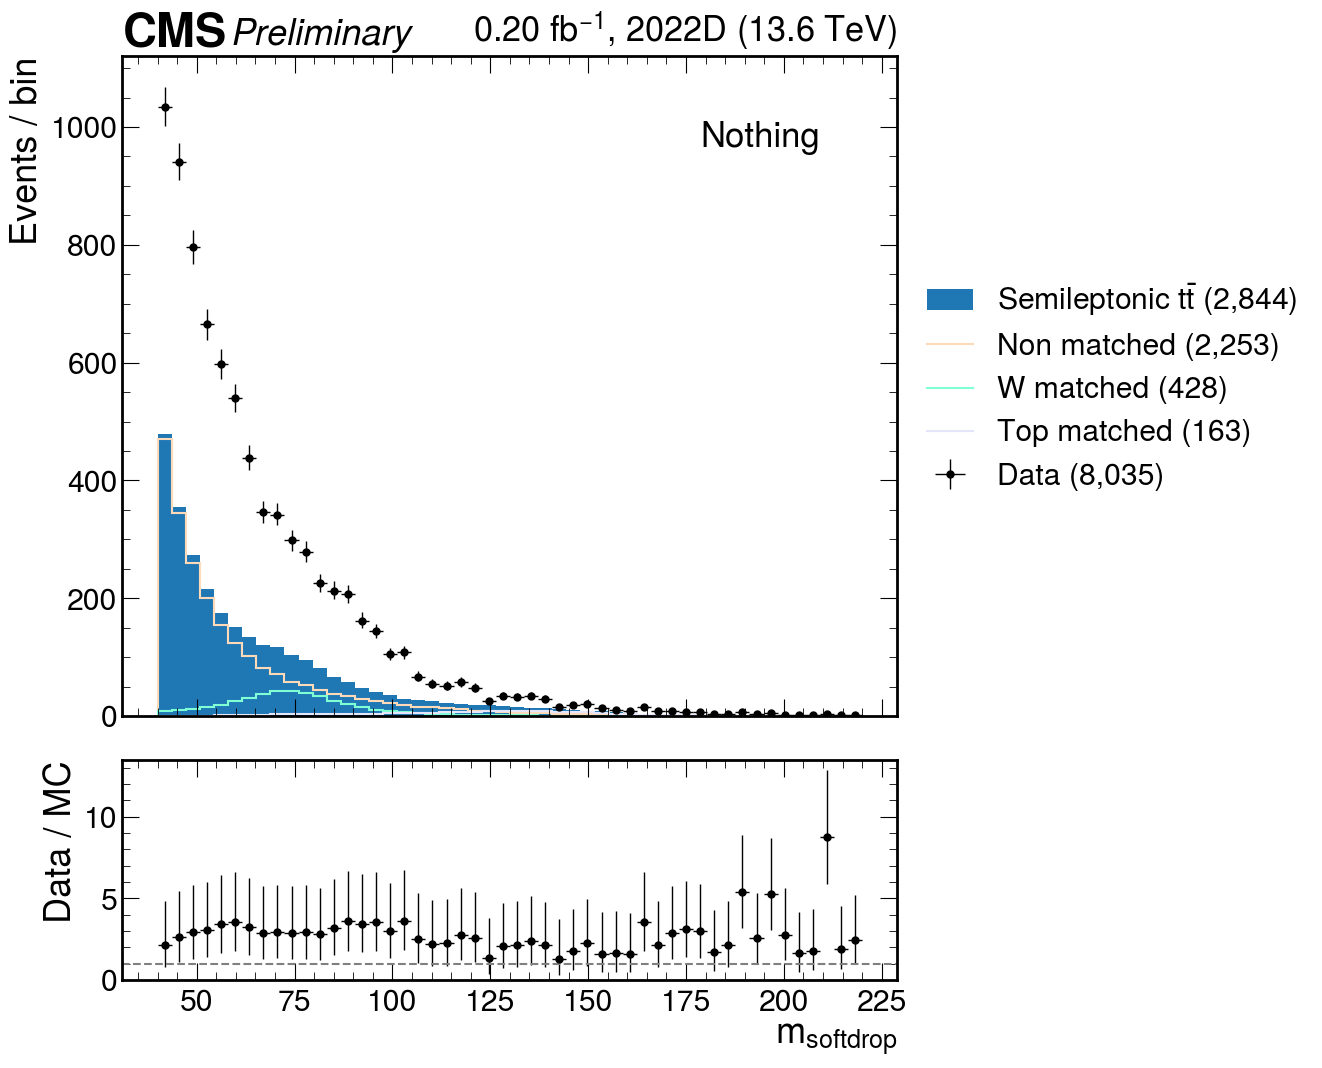

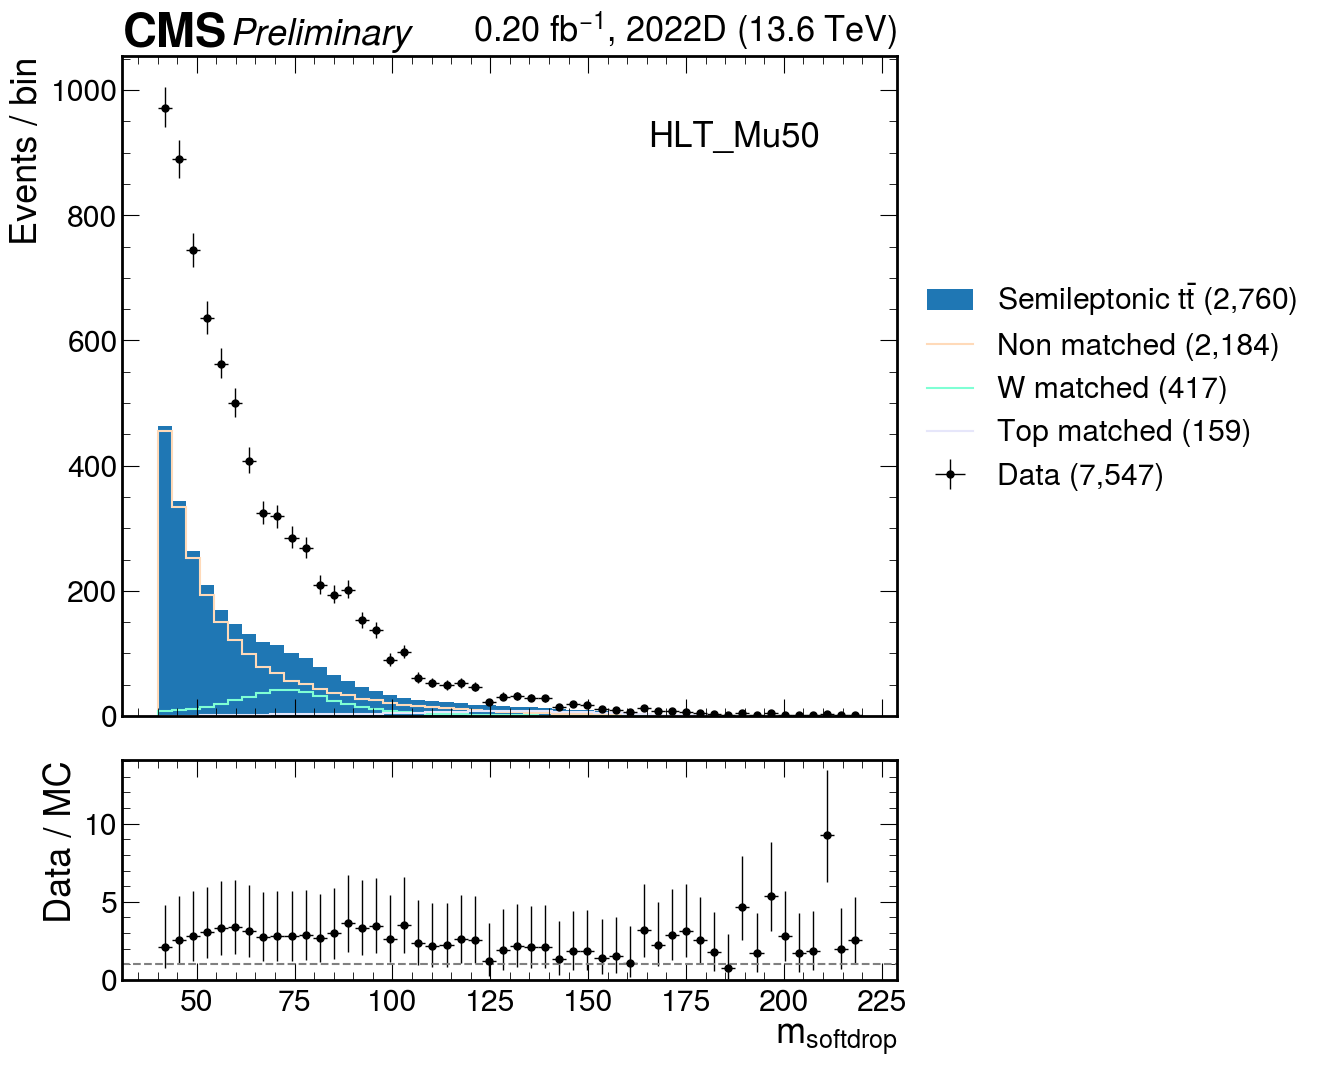

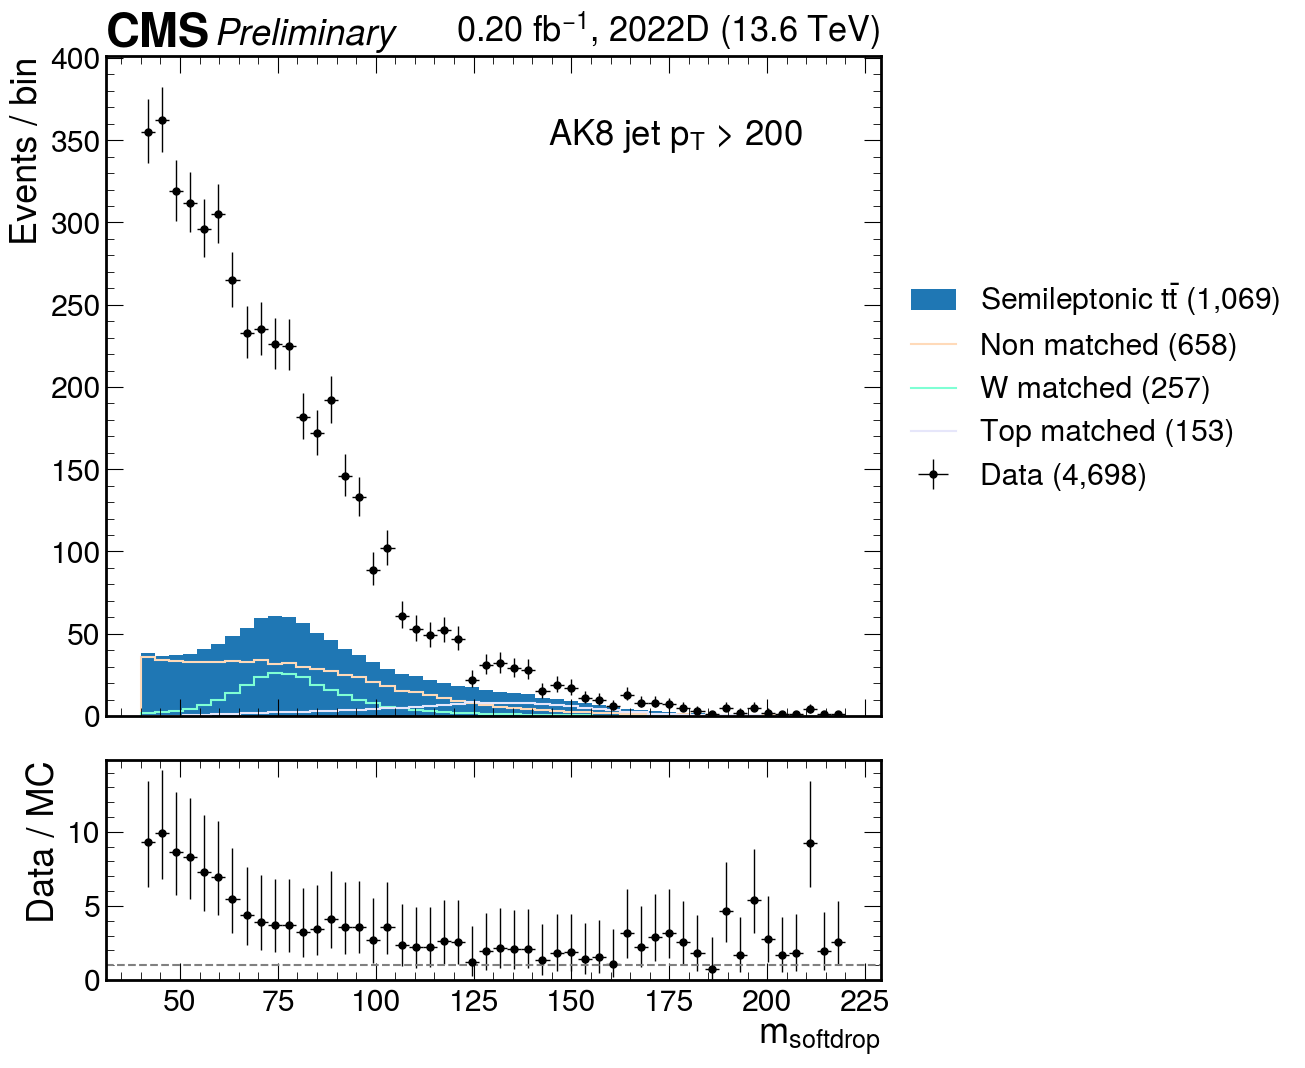

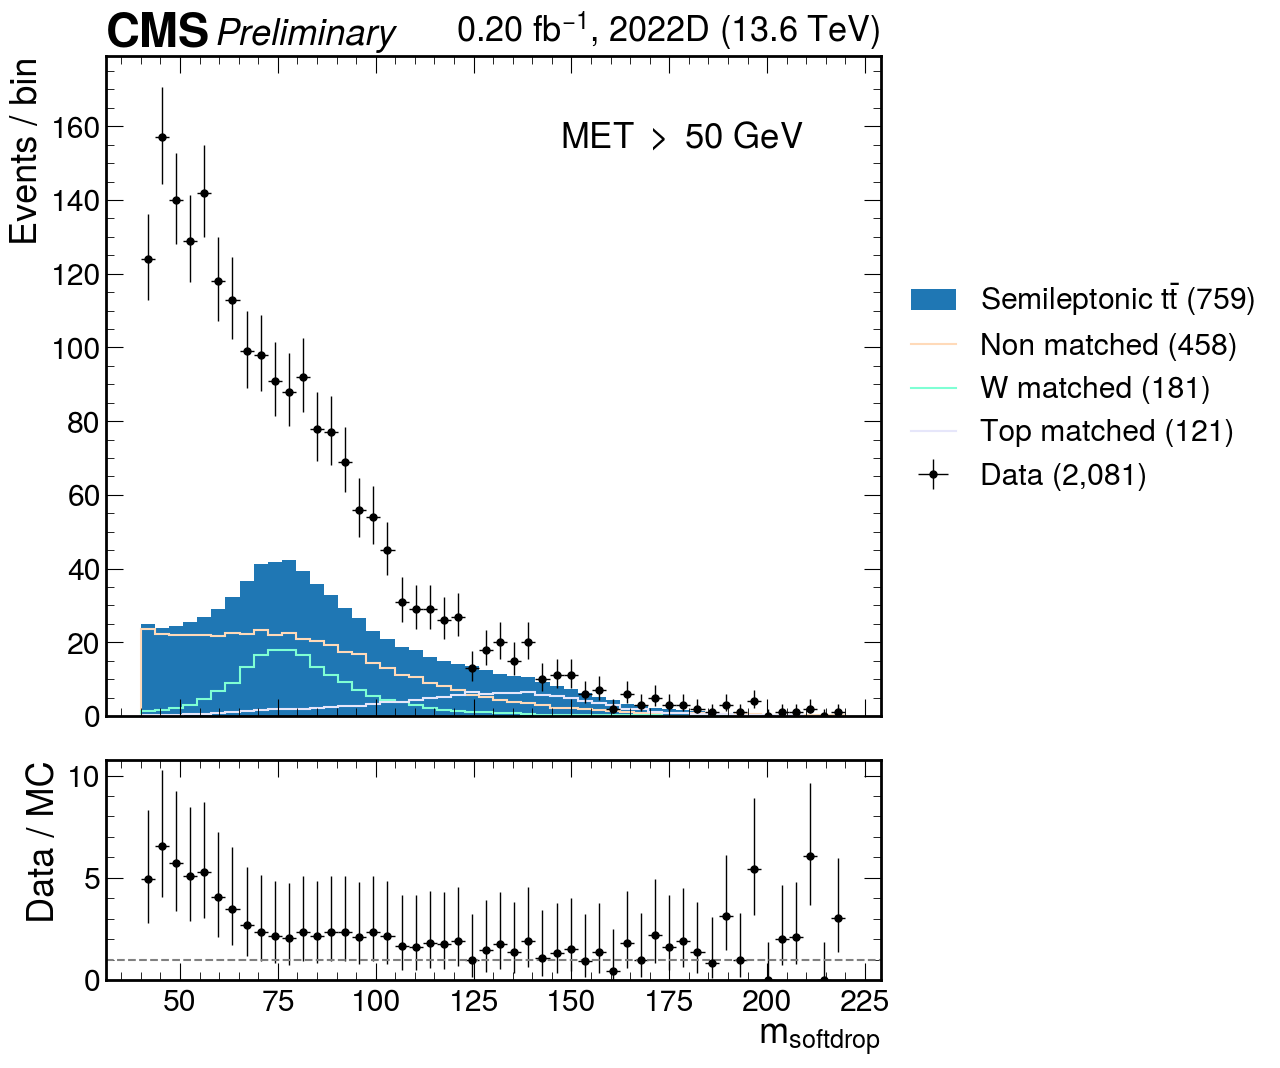

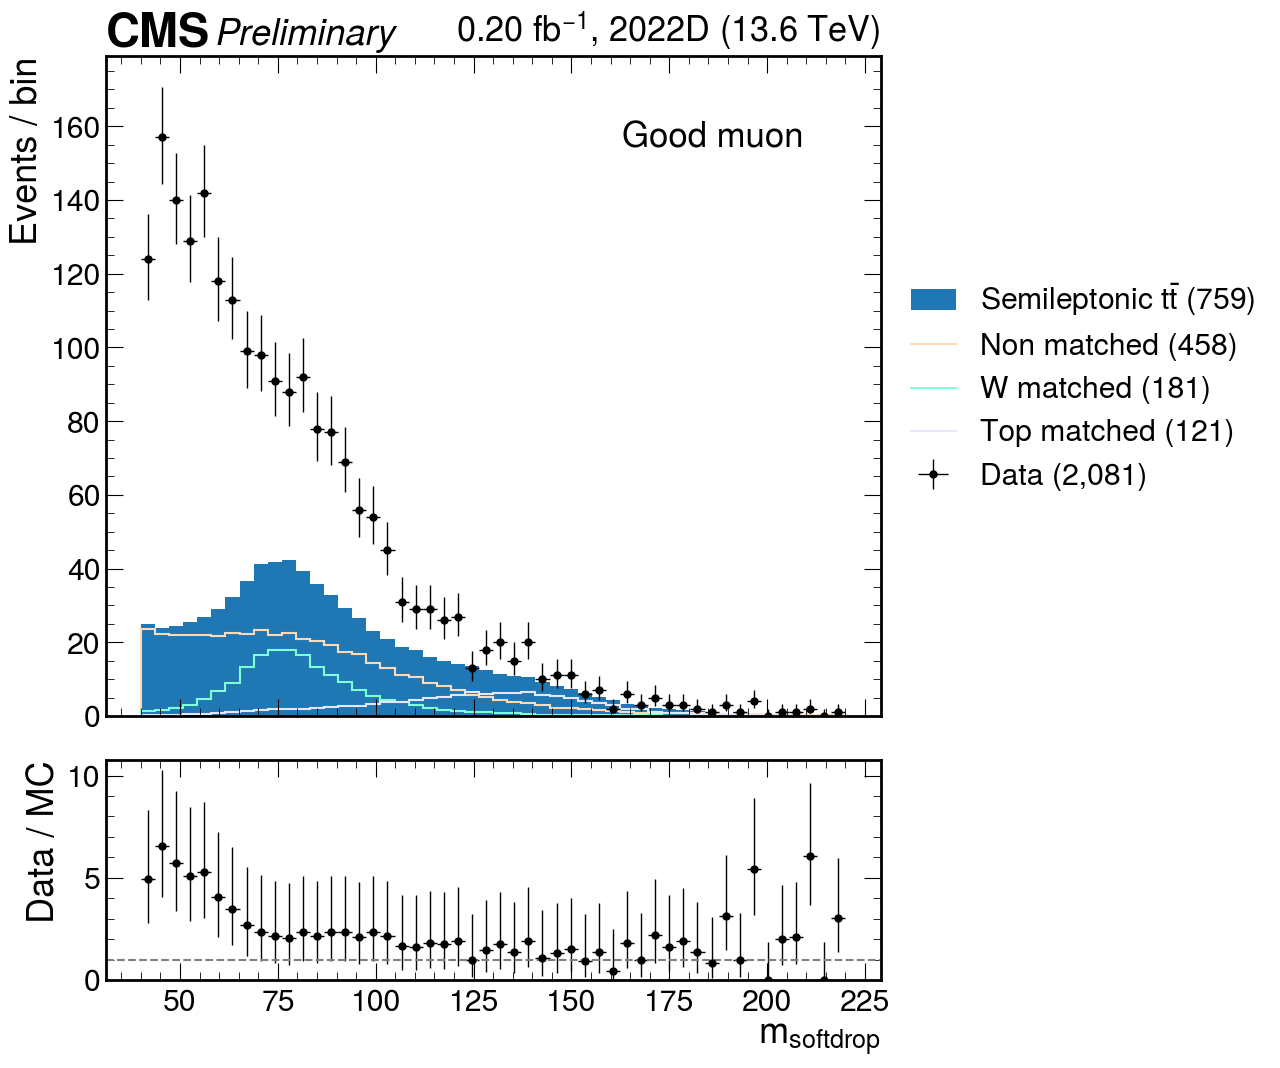

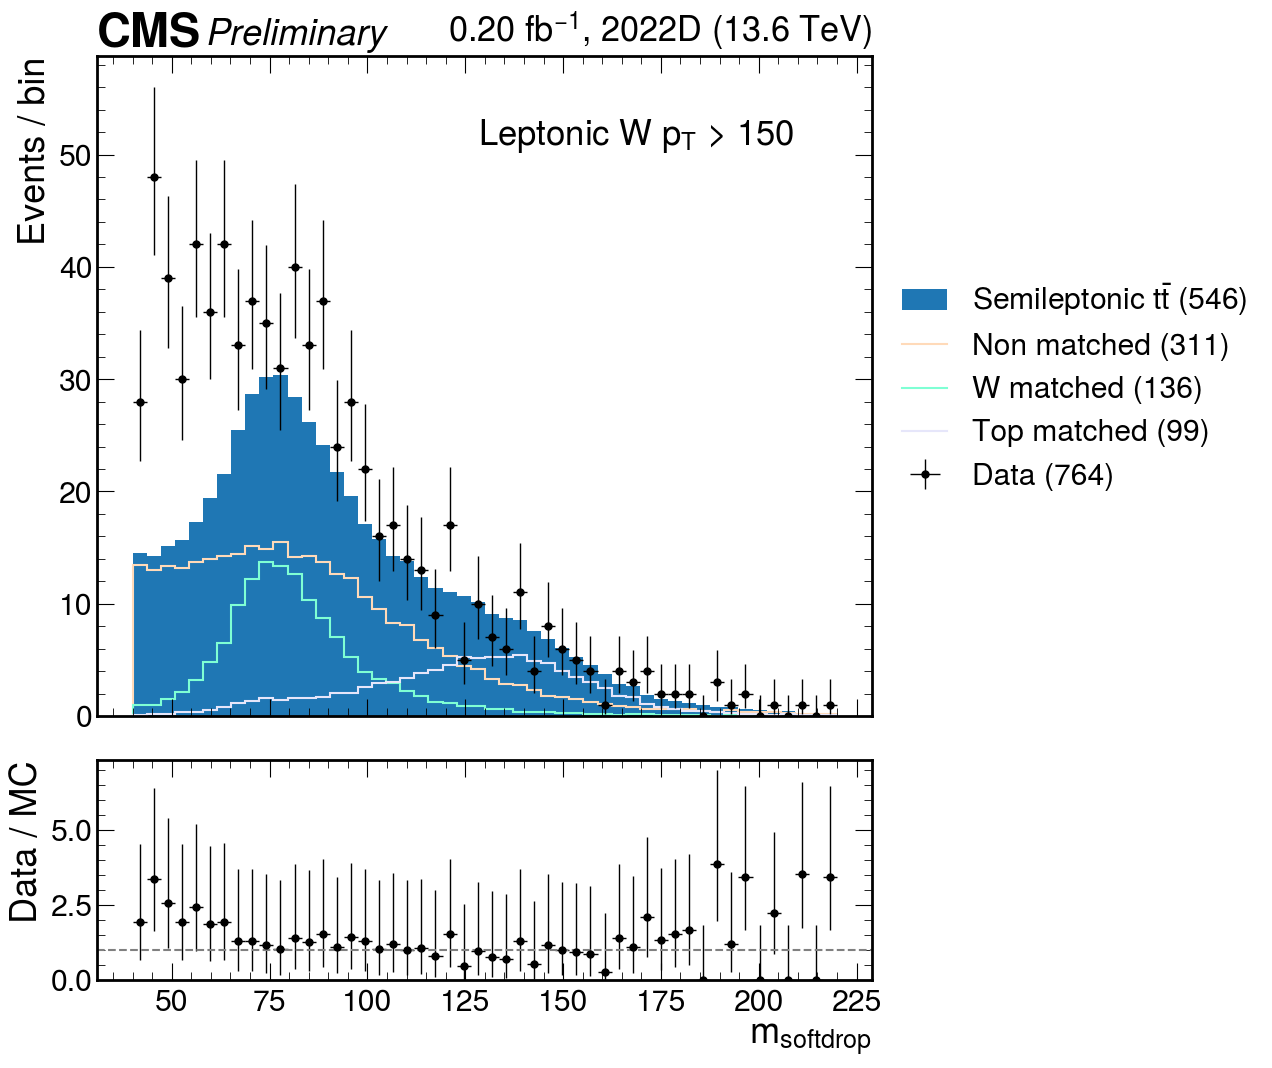

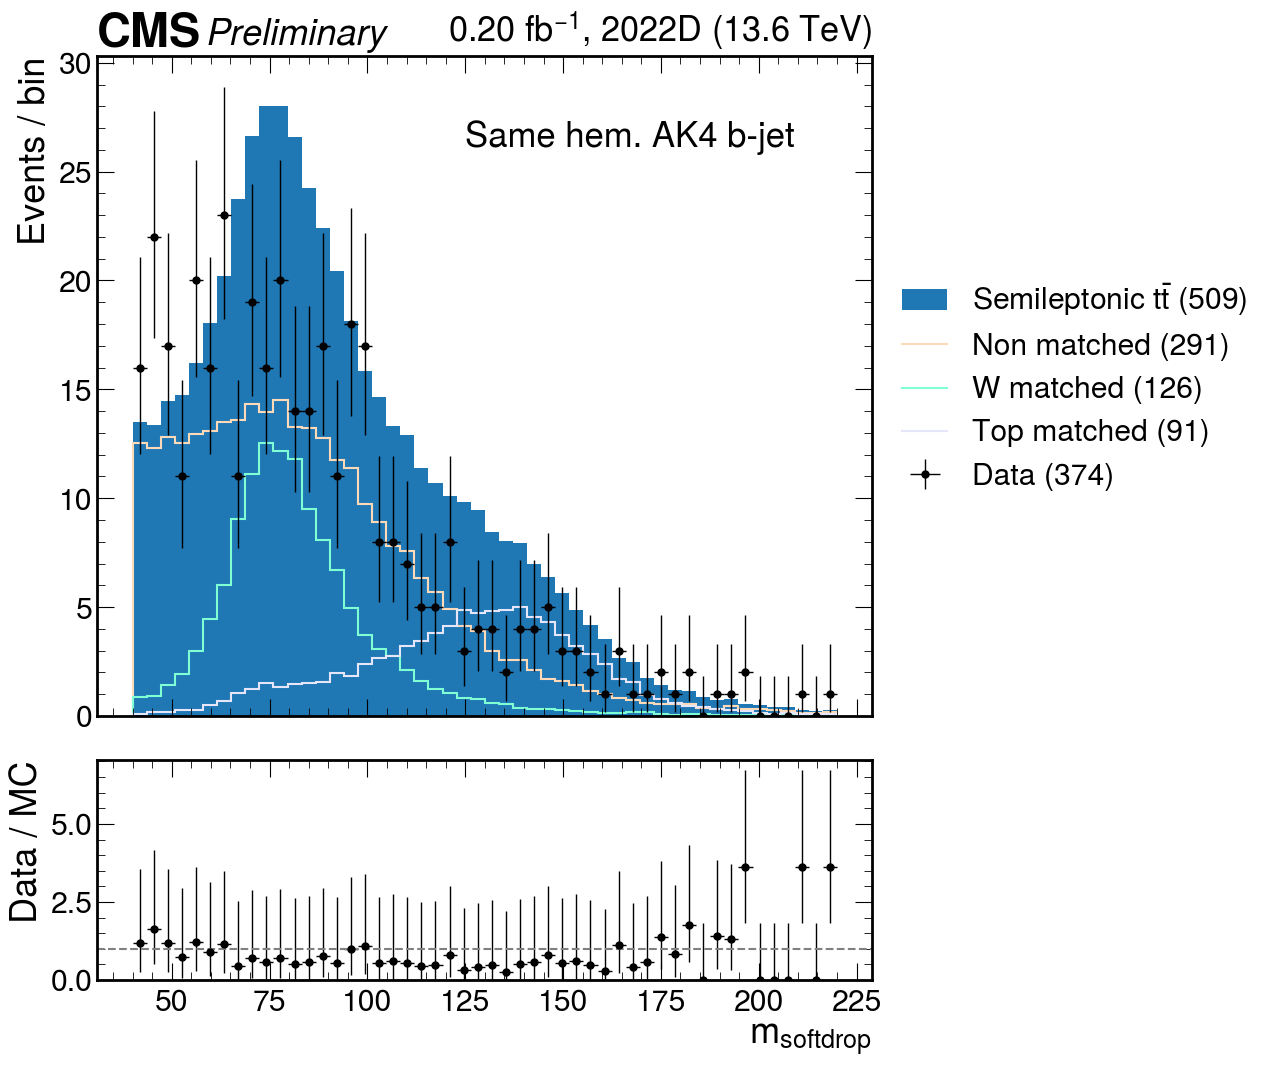

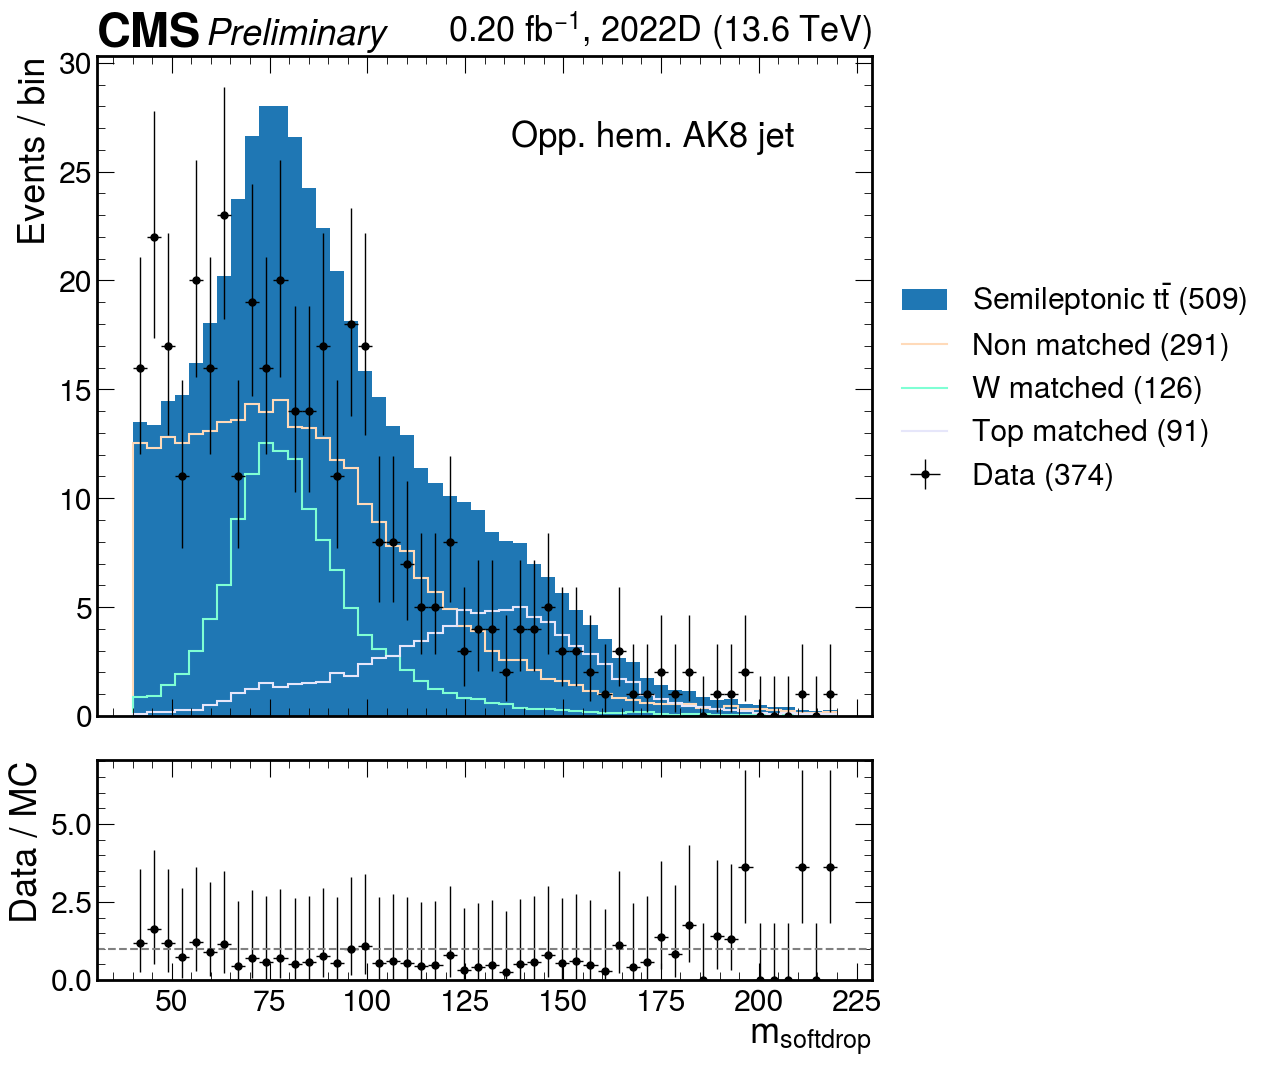

In [37]:
data = util.load("outfiles/old/cutflow_Run2022D.coffea")[0]
mc = util.load("outfiles/old/cutflow_TTtoLNu2Q.coffea")[0]

lumis = {
    "2022d" : 195.928715546,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
]

scale_lumi = {k: xs[k] * 1000 * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "cat" : sum,
    "dataset" : sum, 
    "pn_Hbb" : slice(hist.underflow, hist.overflow, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "pn_Hbb" : slice(hist.underflow, hist.overflow, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_mc[{"cat" : sum}],
        ax=ax, 
        histtype="fill",
        label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum():,.0f})"
    )
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : hist.loc("non_matched")}],
            hh_mc[{"cat" : hist.loc("w_matched")}],
            hh_mc[{"cat" : hist.loc("top_matched")}],
        ],
        ax=ax,
        label=[
            "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("non_matched")}].sum()),
            "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("w_matched")}].sum()),
            "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("top_matched")}].sum()),
        ],
        color=["peachpuff","aquamarine","lavender"]
    )

    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum():,.0f})"
    )

    ratio = hh_data / hh_mc[{"cat" : sum}]
    
    mplhep.histplot(
        ratio, 
        ax=rax, 
        histtype="errorbar",
        xerr=True,
        c="black"
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

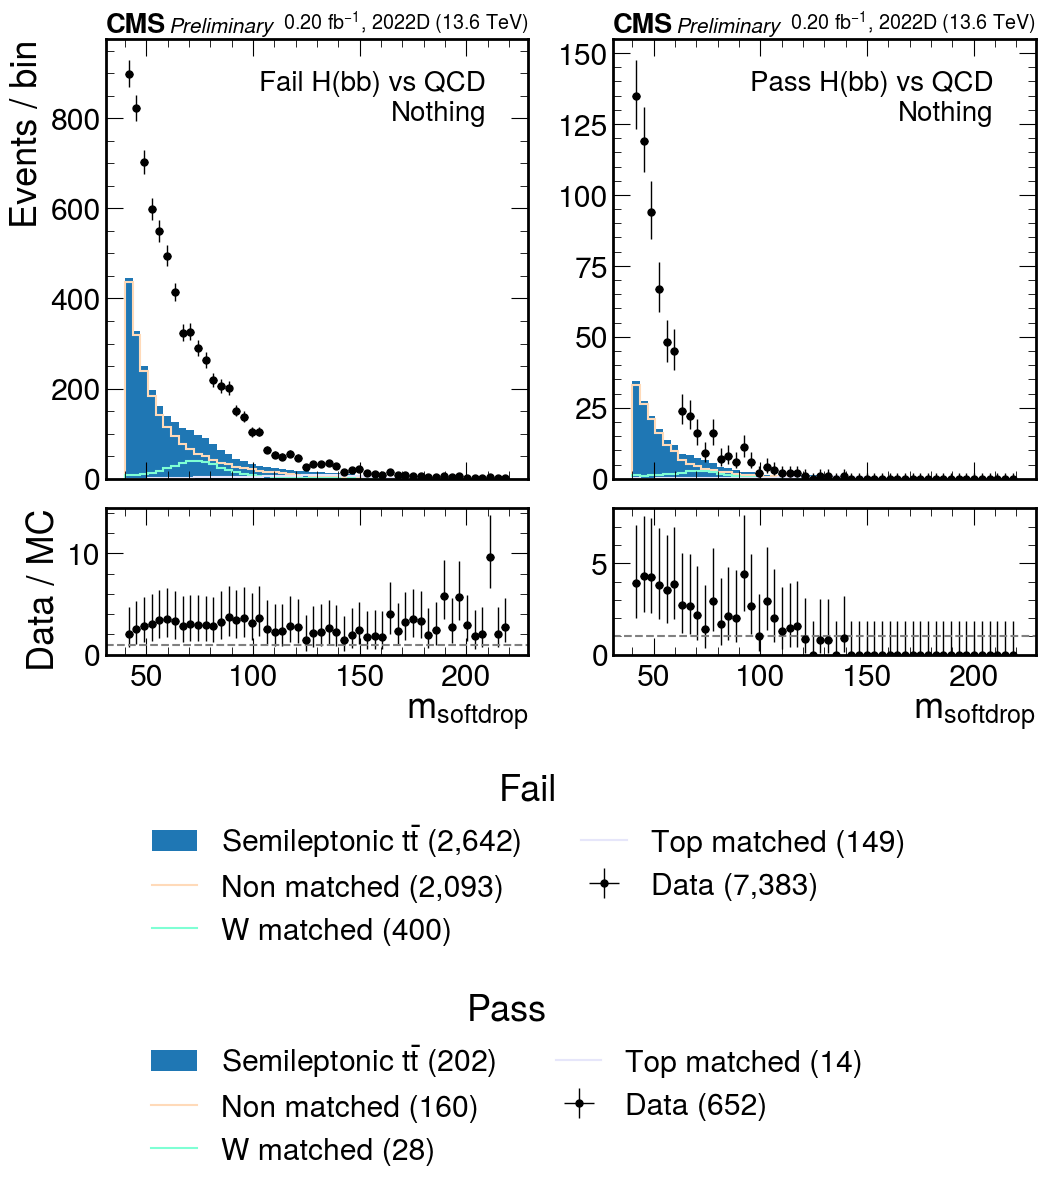

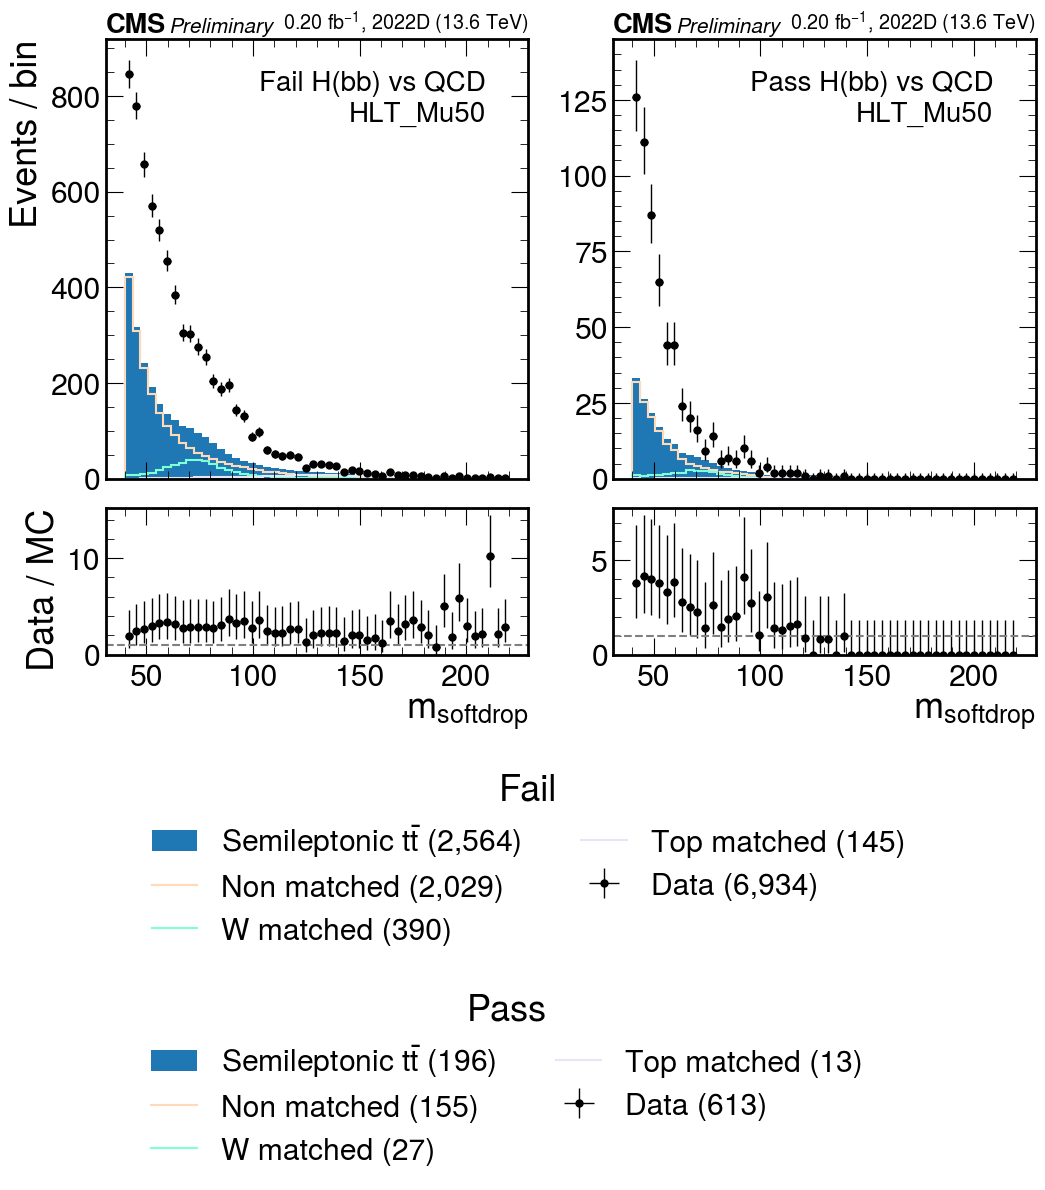

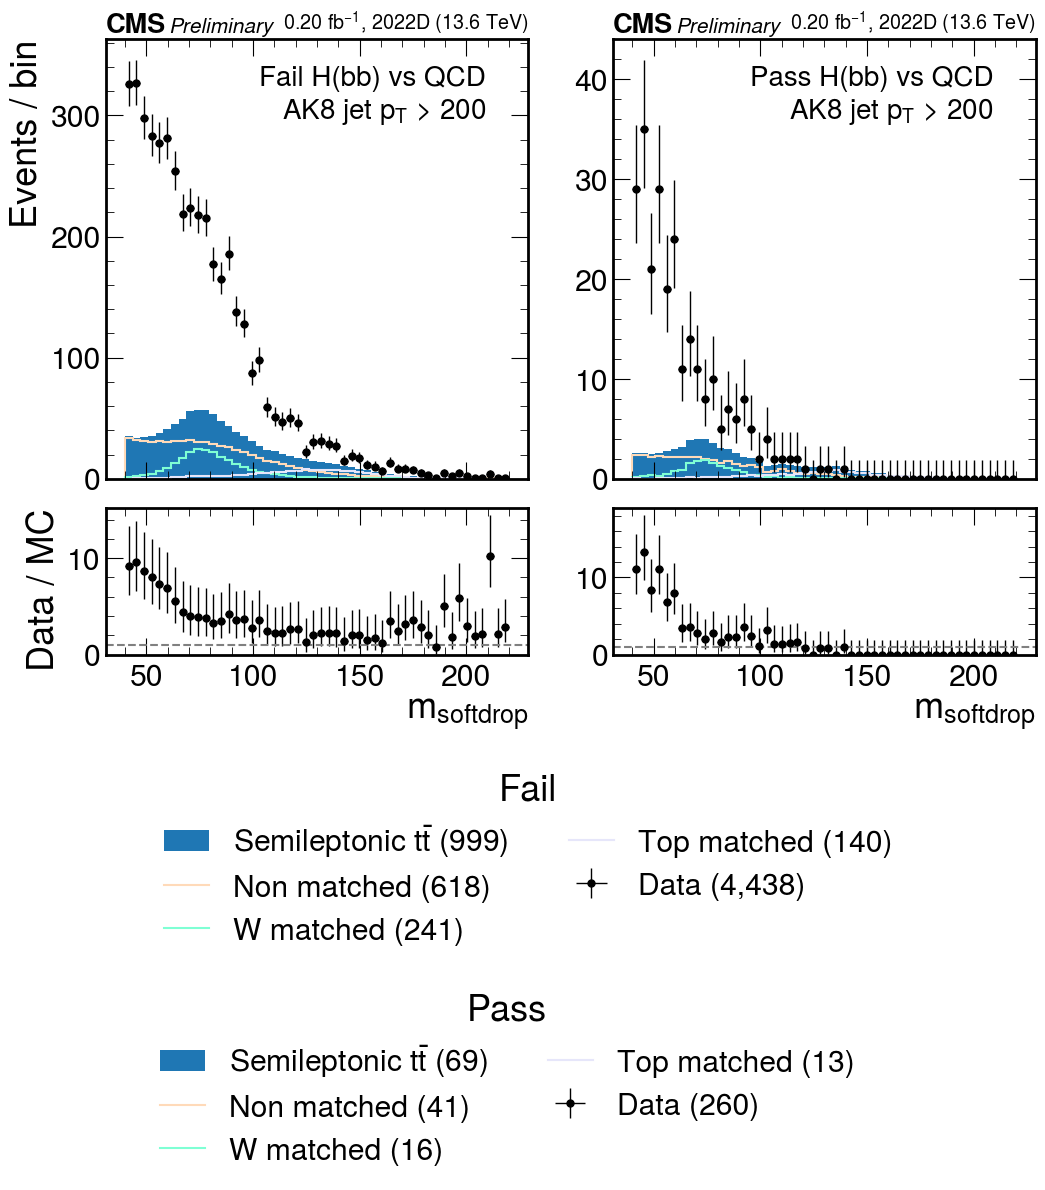

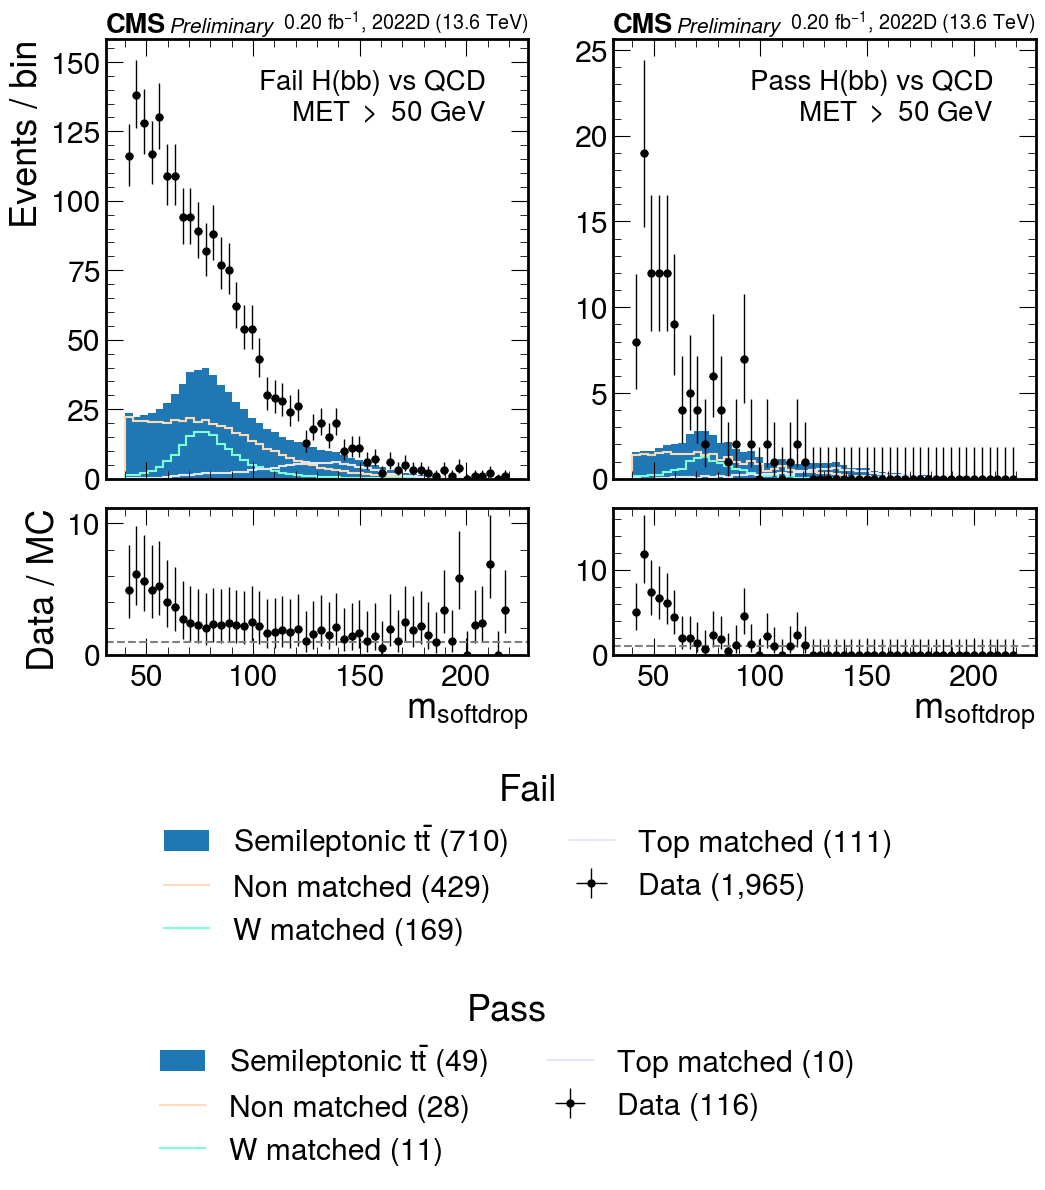

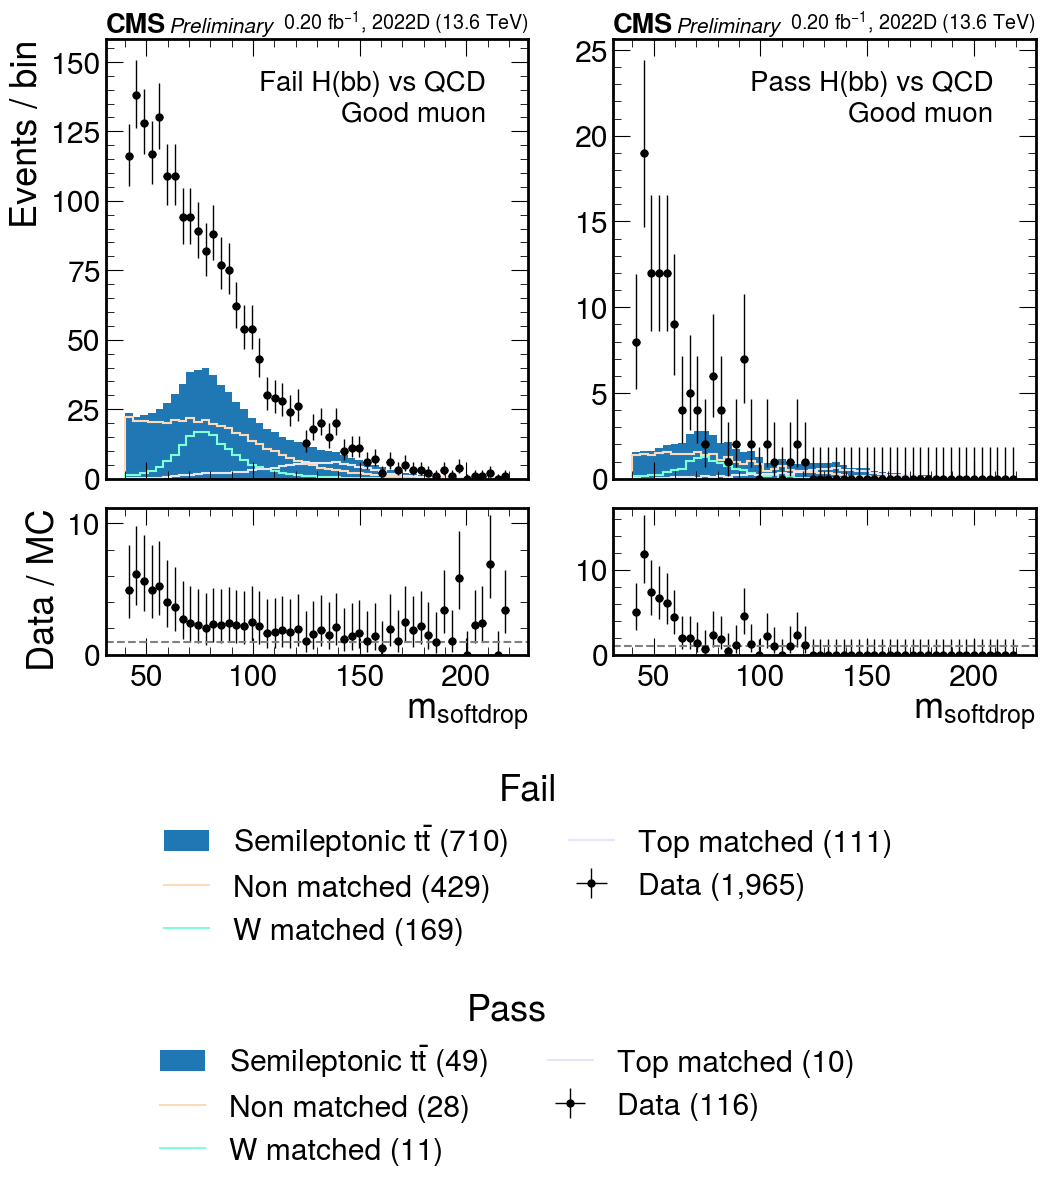

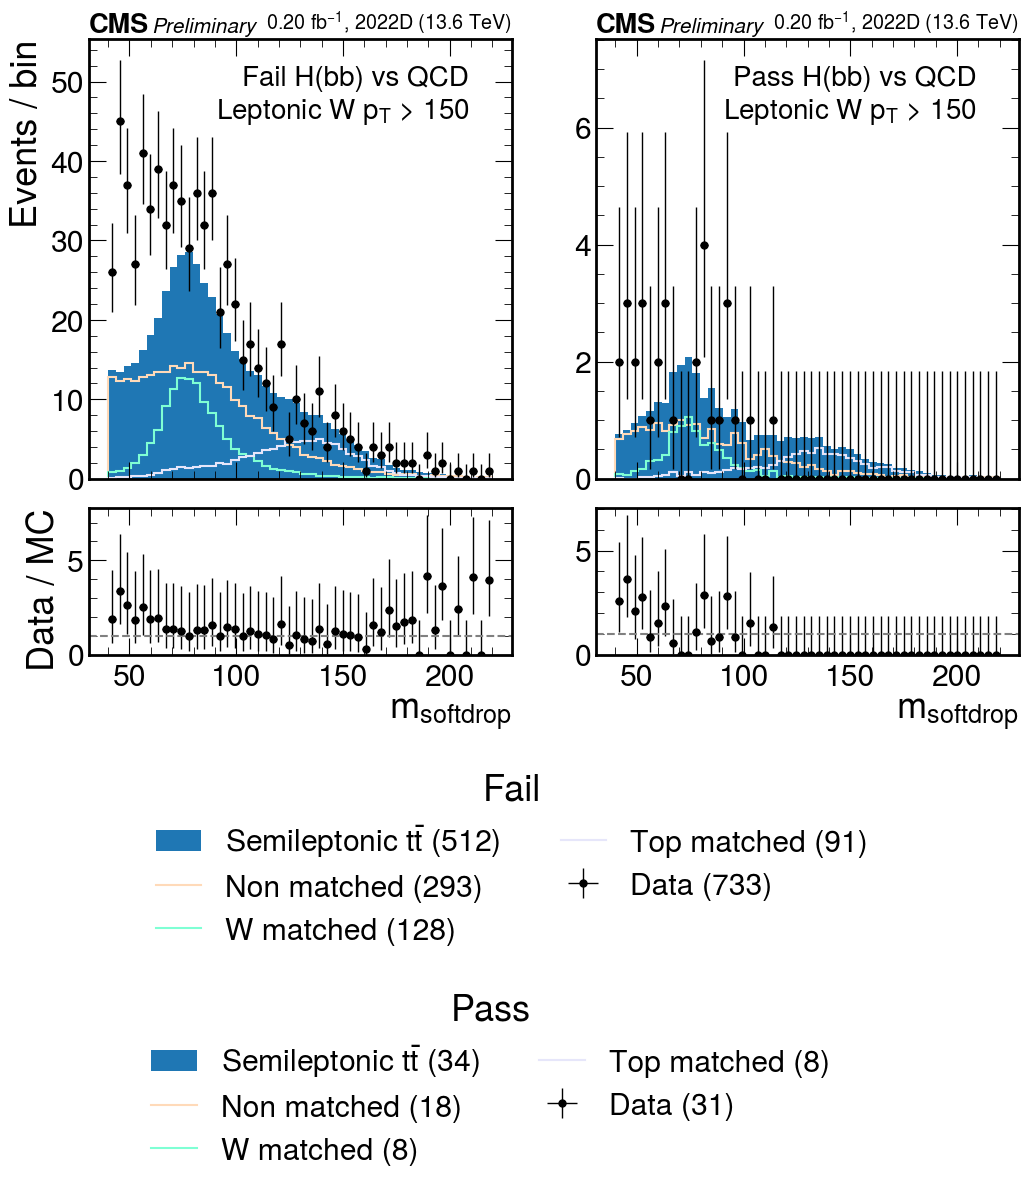

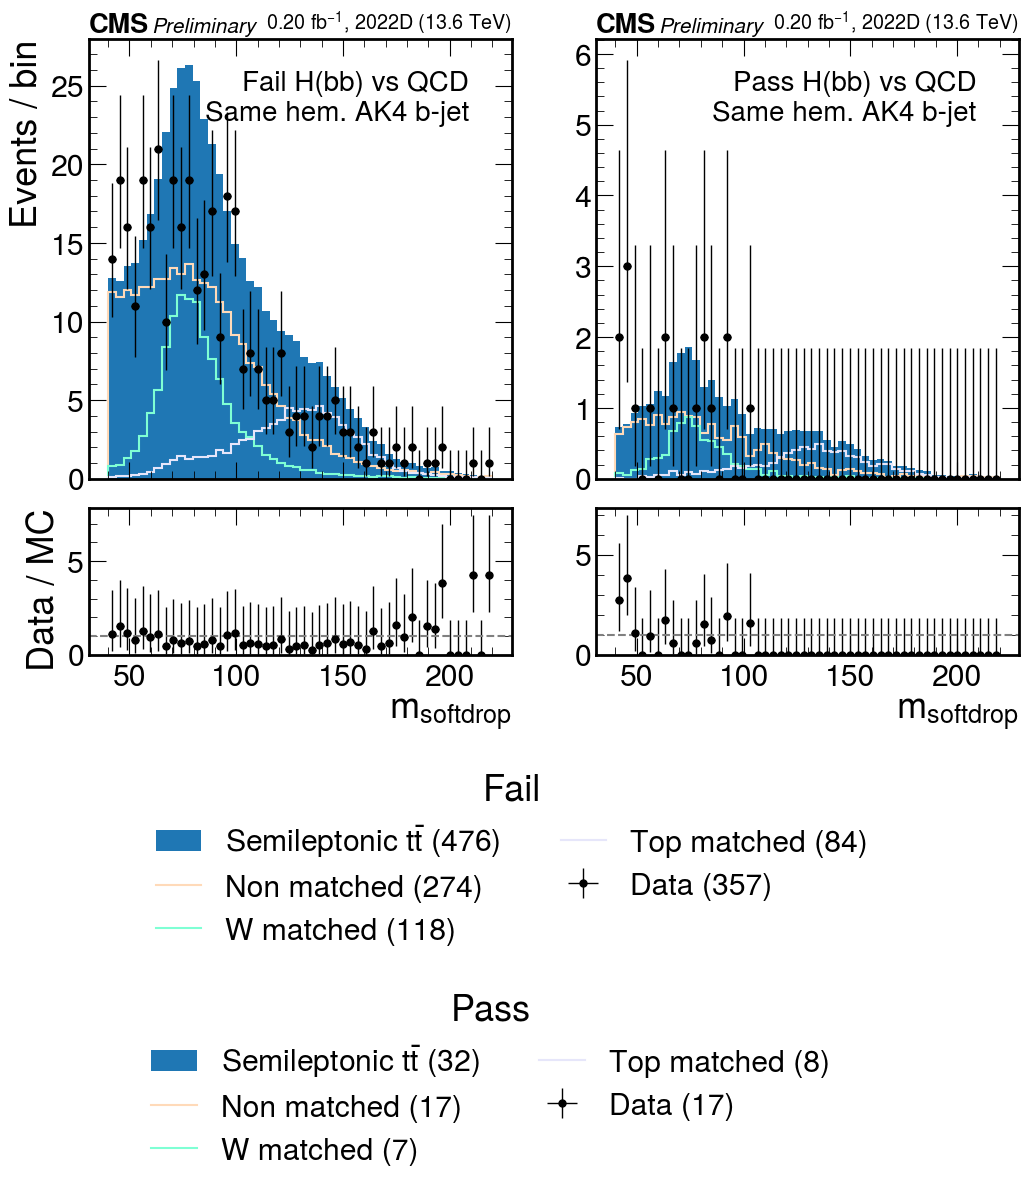

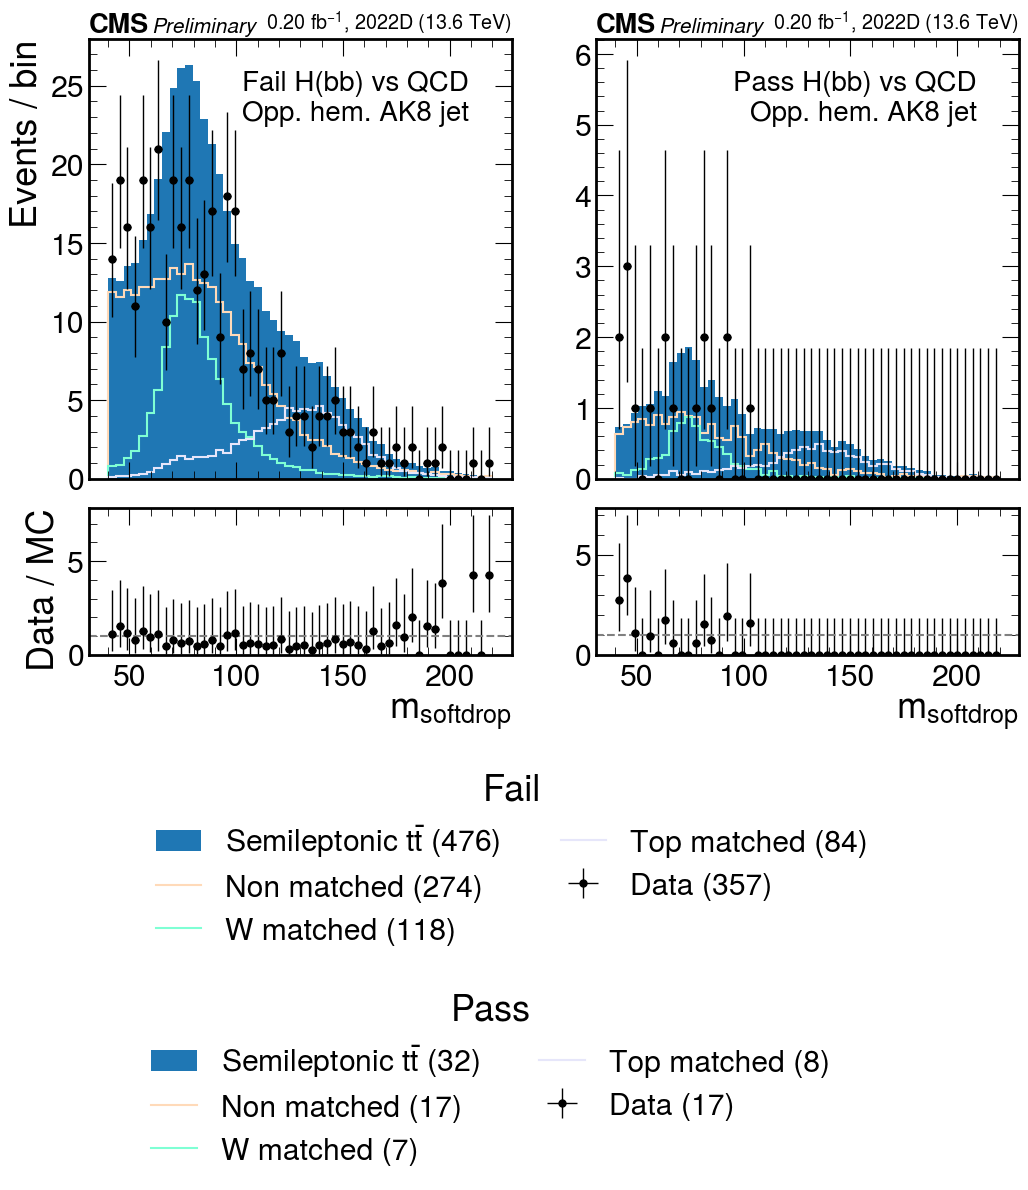

In [39]:
data = util.load("outfiles/old/cutflow_Run2022D.coffea")[0]
mc = util.load("outfiles/old/cutflow_TTtoLNu2Q.coffea")[0]

lumis = {
    "2022d" : 195.928715546,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
]

region = {
    0 : "Fail H(bb) vs QCD",
    1 : "Pass H(bb) vs QCD",
}

scale_lumi = {k: xs[k] * 1000 * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "cat" : sum,
    "dataset" : sum,  
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 2, figsize=(12, 8), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    
    for j, _ in enumerate(["fail", "pass"]):
    
        fig.subplots_adjust(hspace=0.1)
        ax[j].set_ylabel("Events / bin" if j == 0 else " ")
        rax[j].set_ylabel("Data / MC" if j == 0 else " ")
        rax[j].set_xlabel(r"m$_{softdrop}$")
        ax[j].set_xlabel(" ")

        sli = slice(hist.underflow, 0.4j, sum) if j == 0 else slice(0.4j, hist.overflow, sum)
        hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : sli}]

        mplhep.histplot(
            hh_mc[{"cat" : sum}],
            ax=ax[j], 
            histtype="fill",
            label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum():,.0f})"
        )

        mplhep.histplot(
            [
                hh_mc[{"cat" : hist.loc("non_matched")}],
                hh_mc[{"cat" : hist.loc("w_matched")}],
                hh_mc[{"cat" : hist.loc("top_matched")}],
            ],
            ax=ax[j],
            label=[
                "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("non_matched")}].sum()),
                "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("w_matched")}].sum()),
                "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("top_matched")}].sum()),
            ],
            color=["peachpuff","aquamarine","lavender"]
        )

        hh_data = h_data[{"cut" : hist.loc(i), "pn_Hbb" : sli}]

        mplhep.histplot(
            hh_data, 
            ax=ax[j], 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data ({hh_data.sum():,.0f})"
        )

        ratio = hh_data/hh_mc[{"cat" : sum}]

        mplhep.histplot(
            ratio, 
            ax=rax[j], 
            histtype="errorbar",
            xerr=True,
            c="black"
        )

        rax[j].axhline(1, color='gray',ls='--')

        plt.text(0.9, 0.8, f"{region[j]}\n{cuts[i]}",
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform=ax[j].transAxes
                   )

        mplhep.cms.label(
            ax=ax[j], 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
            fontsize=15,
        )
        
    ax[0].legend(loc='upper center', title="Fail", bbox_to_anchor=(1, -0.6), ncol=2)
    ax[1].legend(loc='upper center', title="Pass", bbox_to_anchor=(-0.25, -1.1), ncol=2)

/srv/.env/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


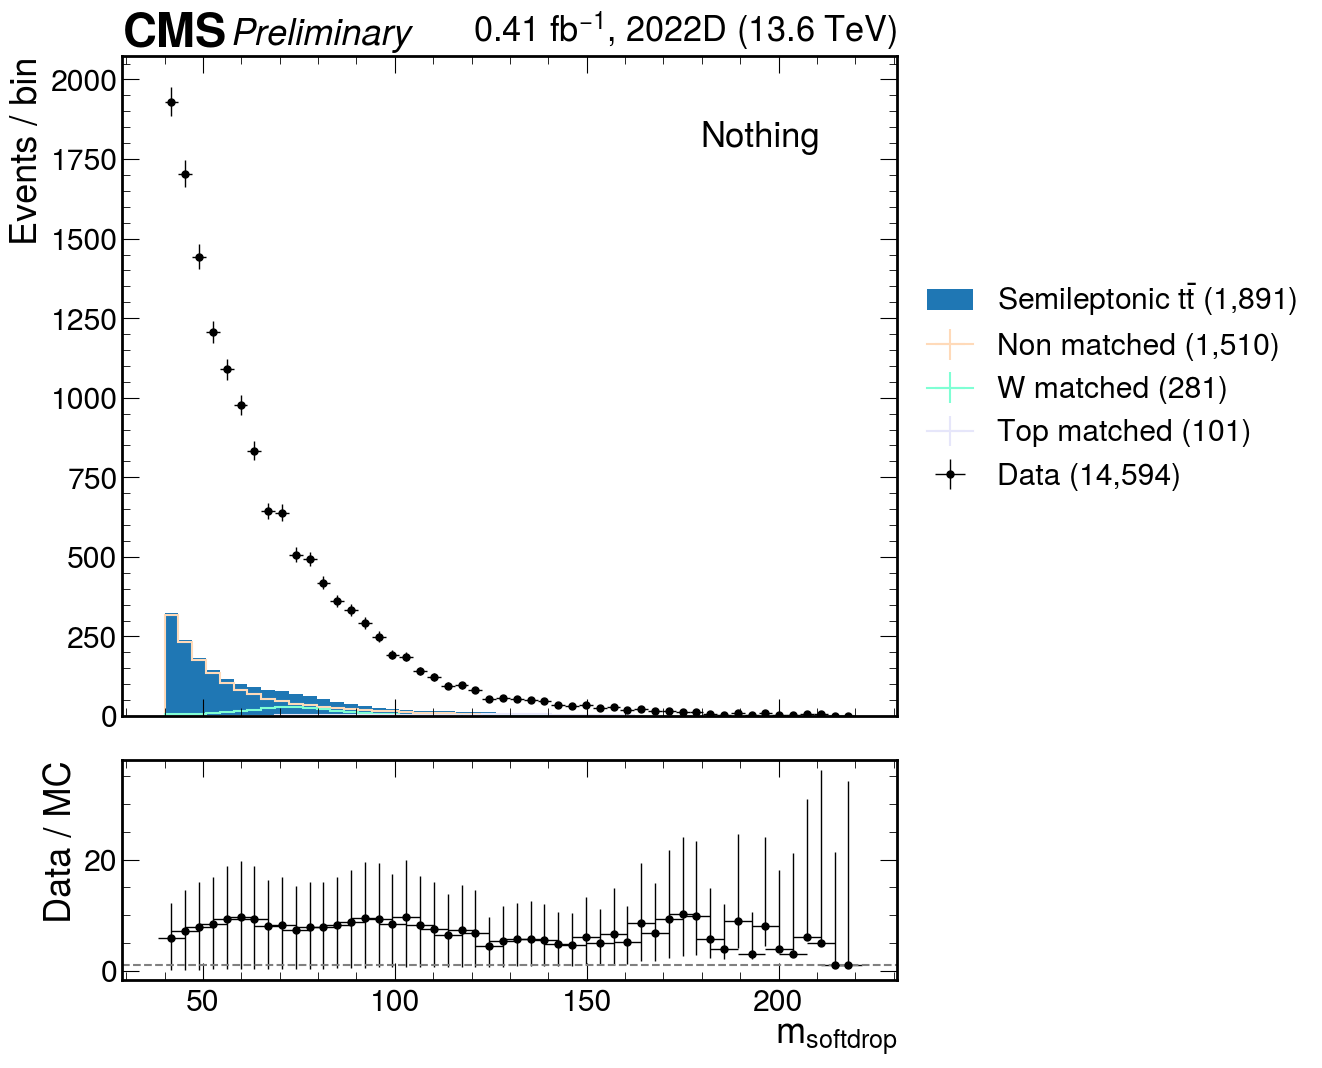

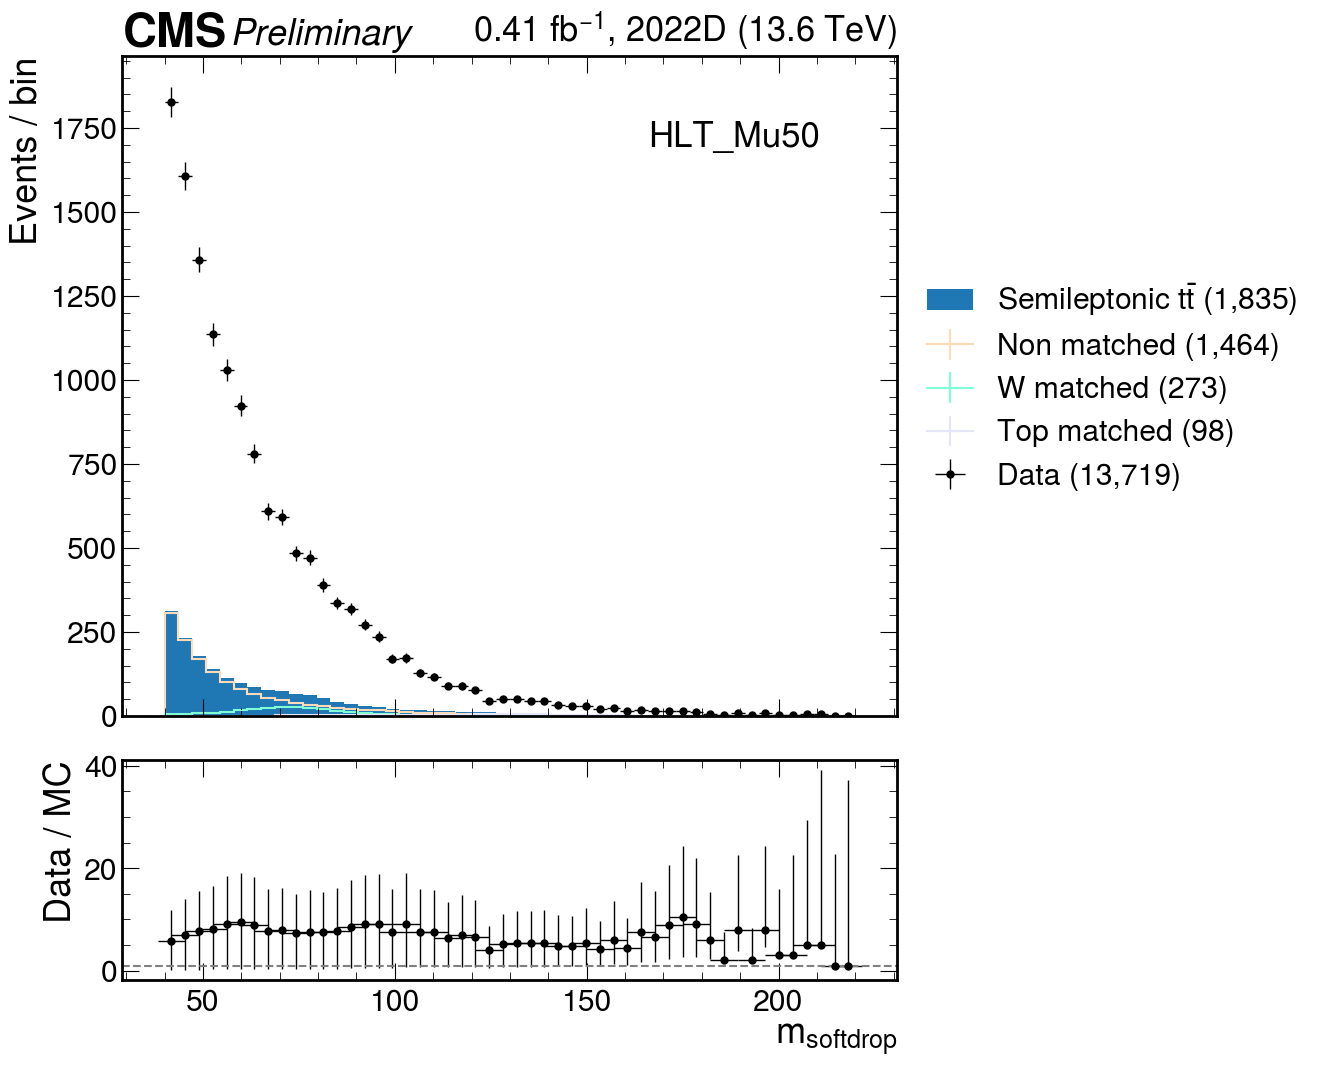

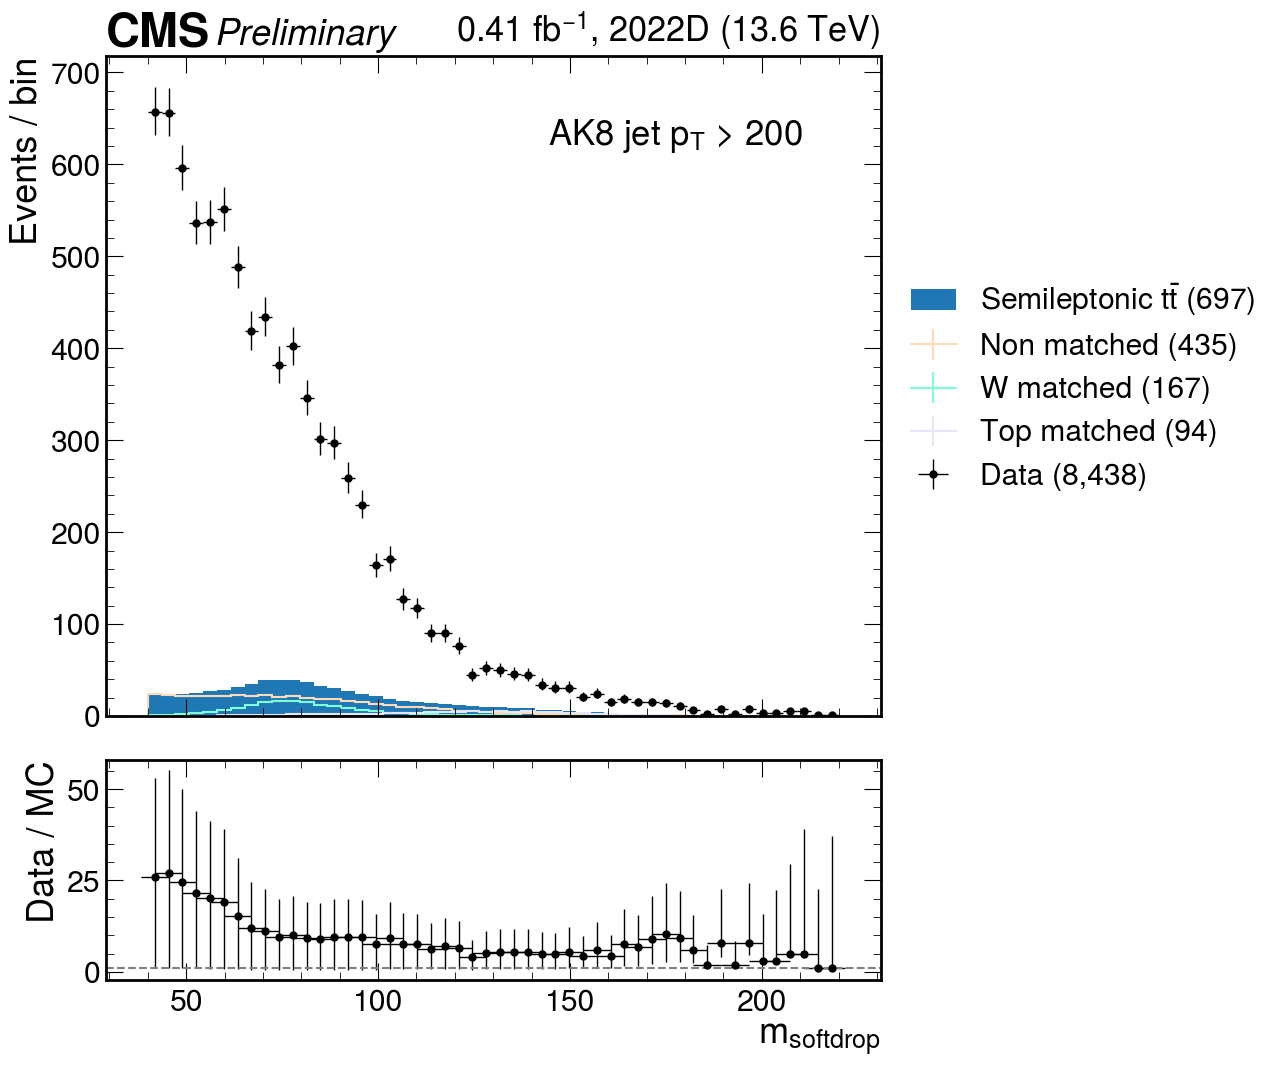

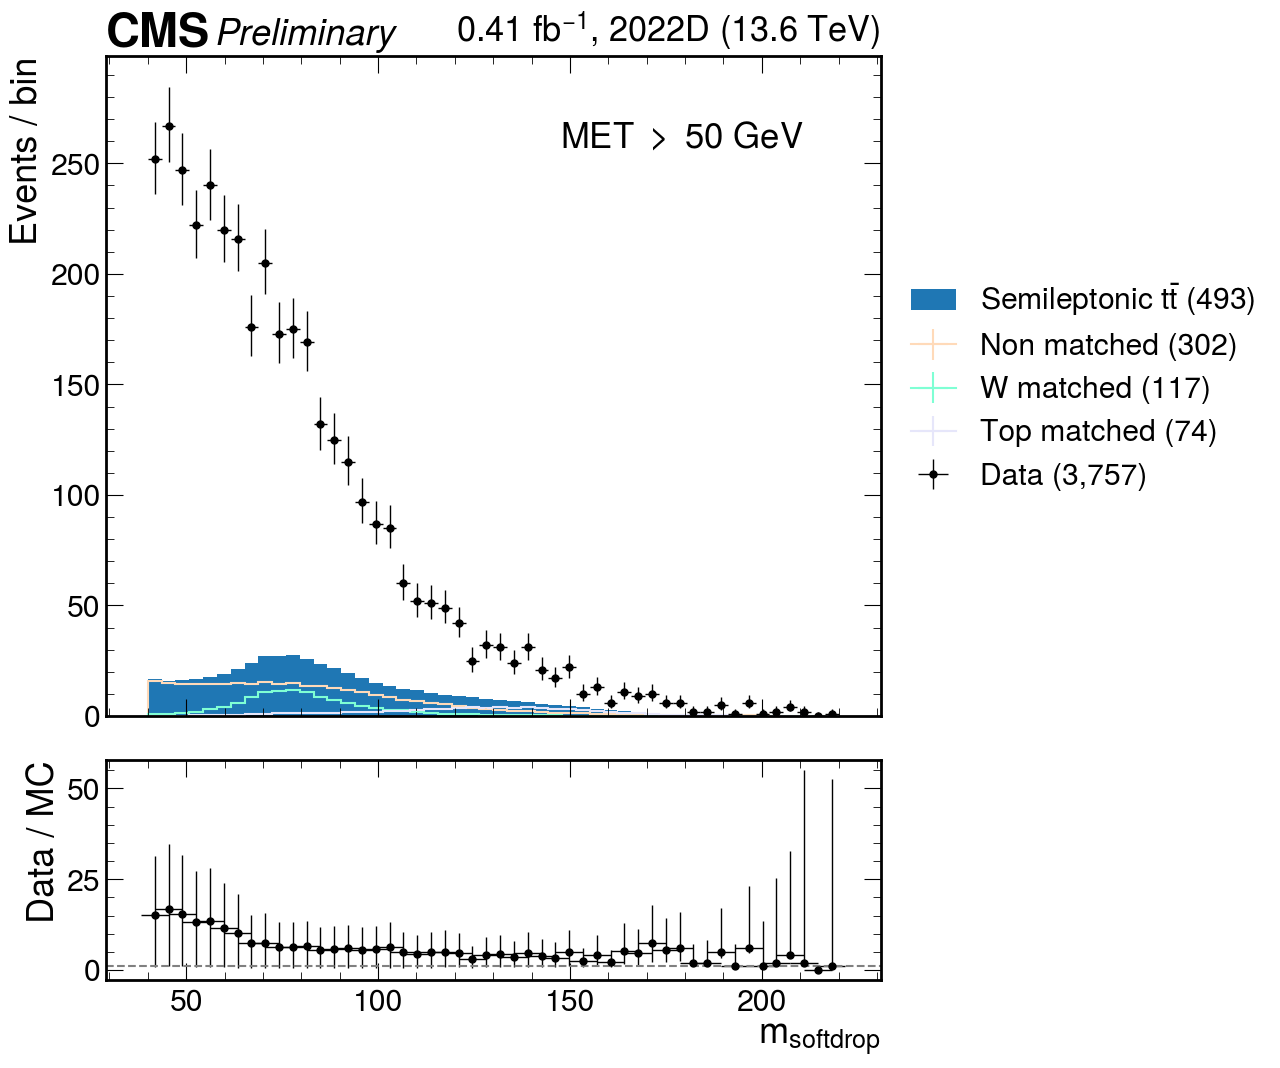

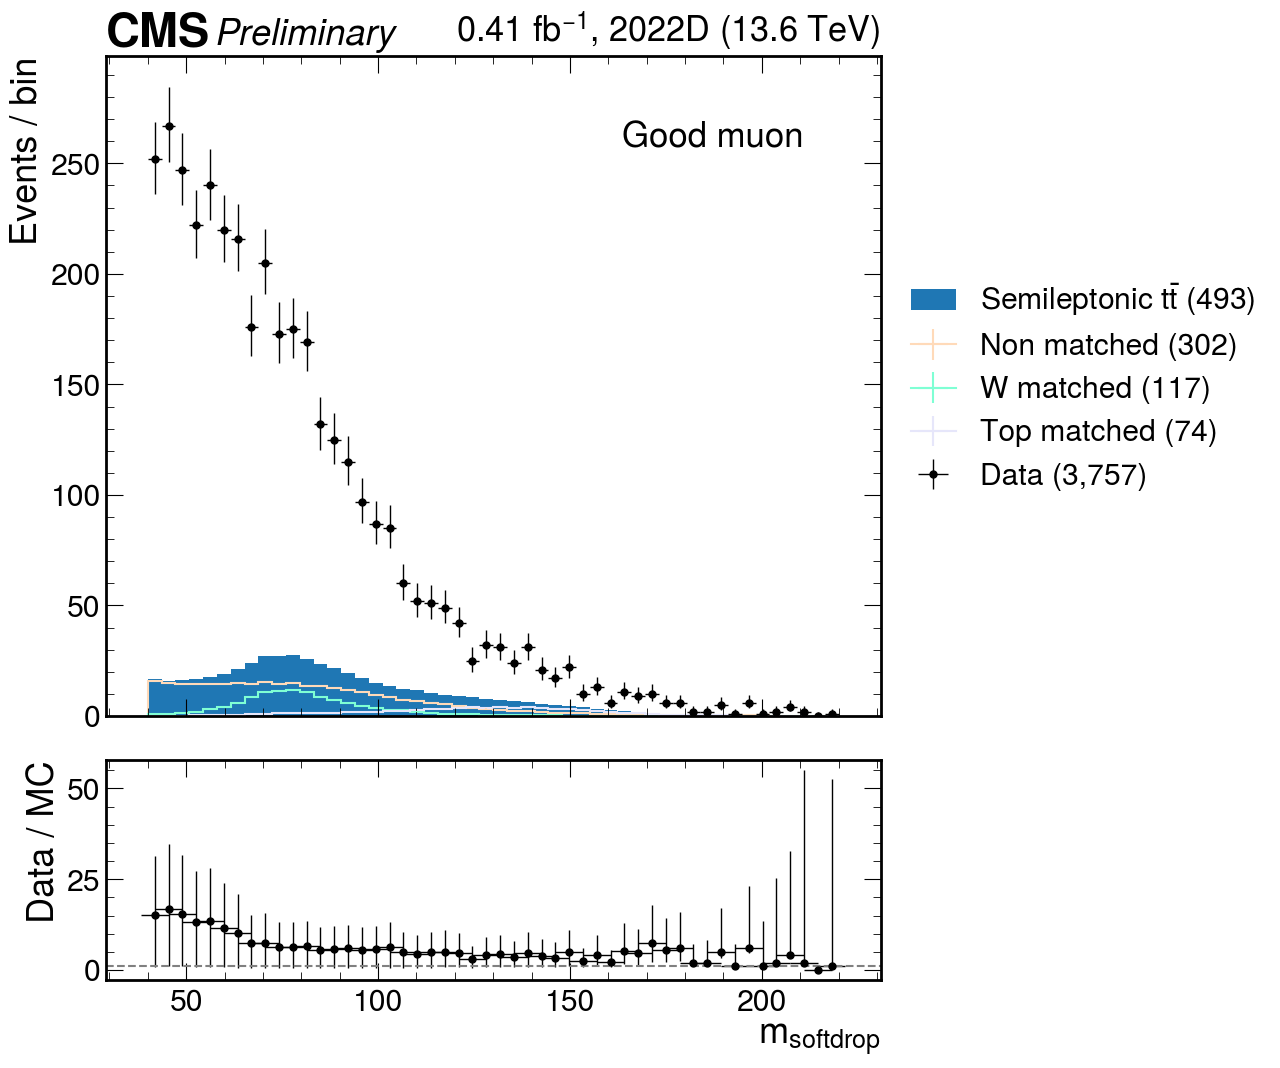

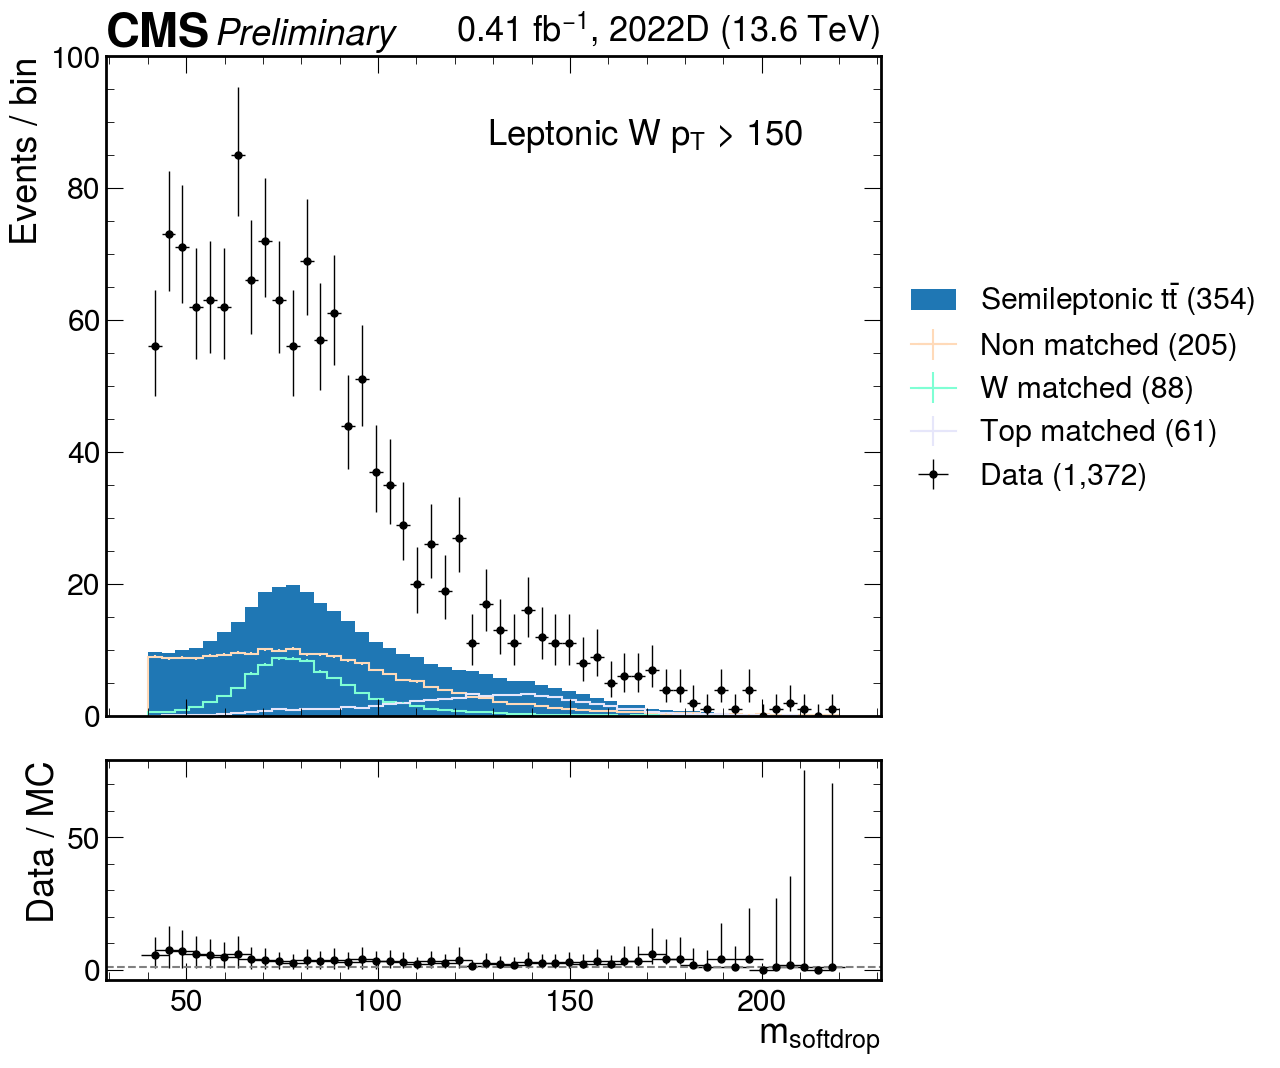

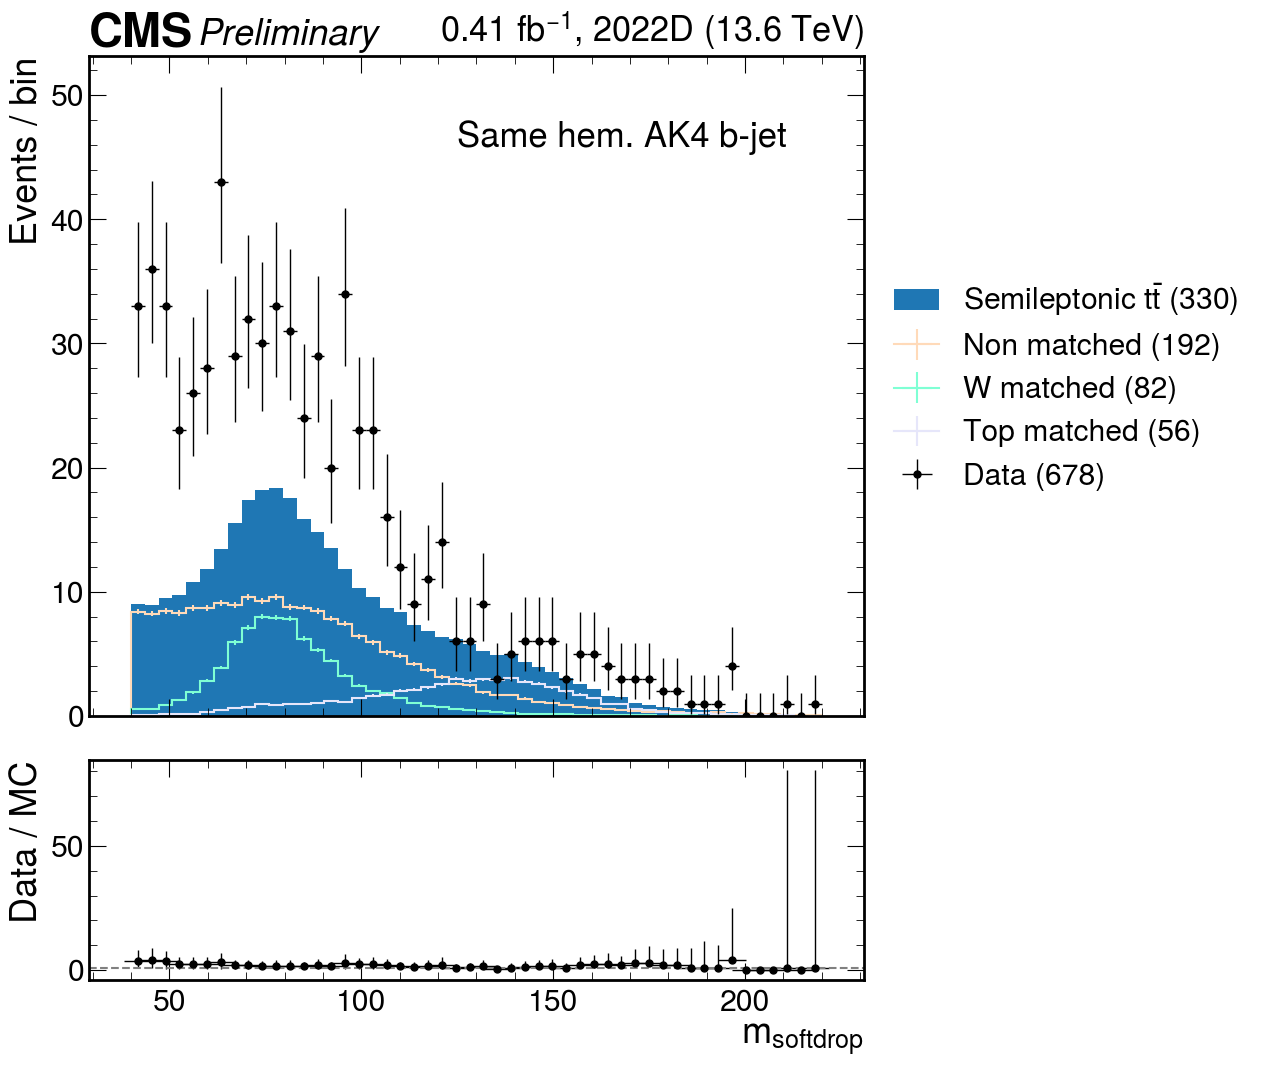

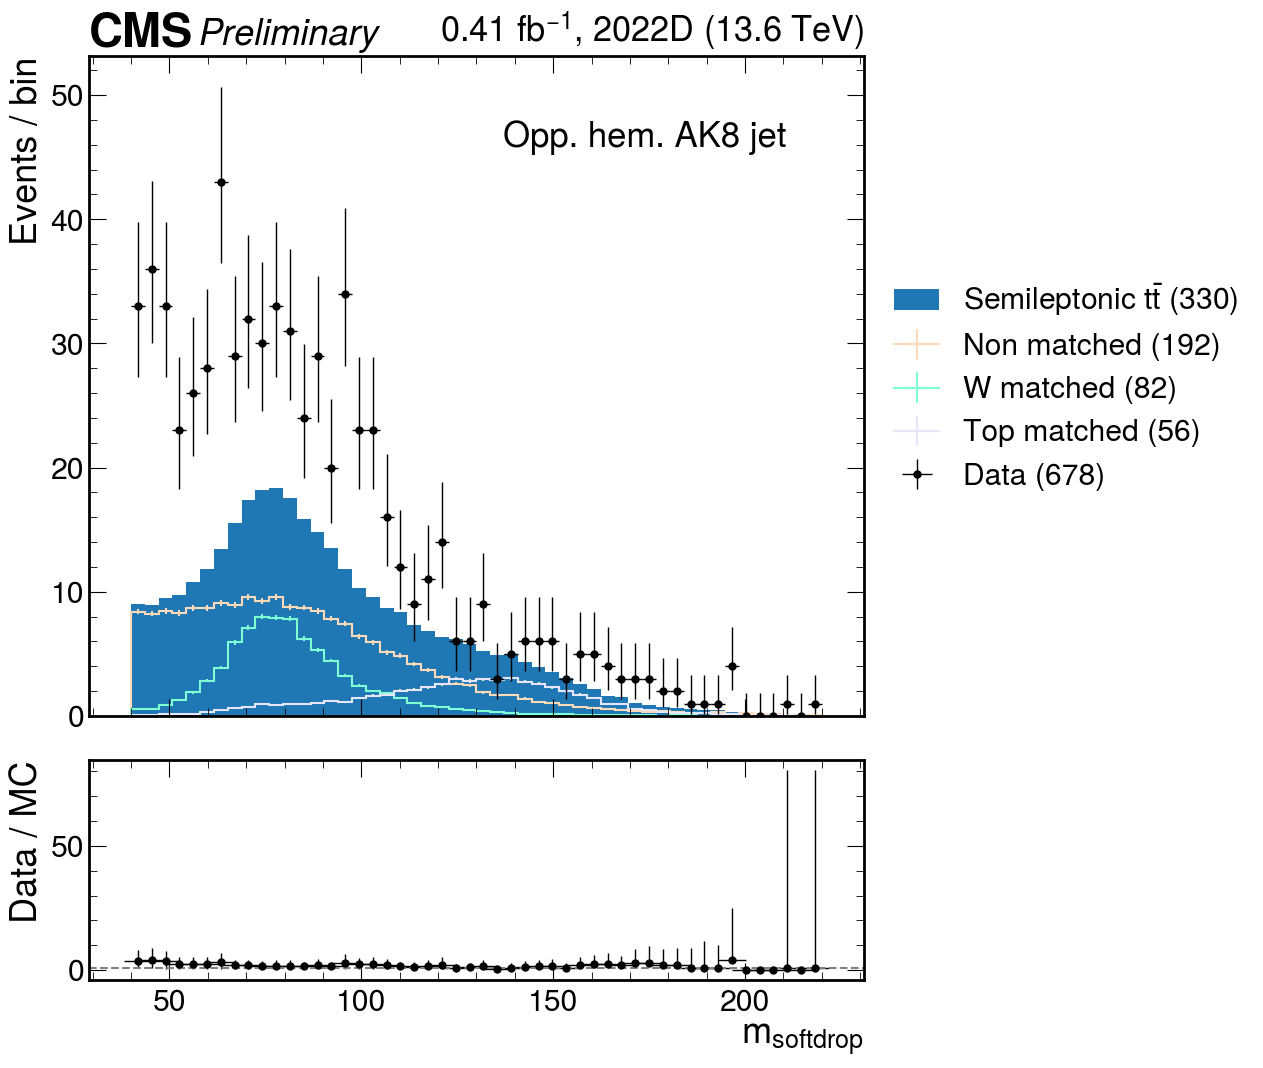

In [2]:
from coffea.hist import clopper_pearson_interval, poisson_interval

data = util.load("outfiles/cutflow_Run2022D.coffea")[0]
mc = util.load("outfiles/cutflow_TTtoLNu2Q_backup.coffea")

lumis = {
    "2022d" : 405.716280863,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
]

scale_lumi = {k: xs[k] * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "cat" : slice(hist.underflow, hist.overflow, sum),
    "dataset" : slice(hist.underflow, hist.overflow, sum),
    "pn_Hbb" : slice(hist.underflow, hist.overflow, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "pn_Hbb" : slice(hist.underflow+1, hist.overflow-1, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_mc[{"cat" : sum}],
        ax=ax, 
        histtype="fill",
        label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})"
    )
    
    mplhep.histplot(
        [
            hh_mc[{"cat" : hist.loc("non_matched")}],
            hh_mc[{"cat" : hist.loc("w_matched")}],
            hh_mc[{"cat" : hist.loc("top_matched")}],
        ],
        ax=ax,
        label=[
            "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("non_matched")}].sum().value),
            "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("w_matched")}].sum().value),
            "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("top_matched")}].sum().value),
        ],
        color=["peachpuff","aquamarine","lavender"]
    )

    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum().value:,.0f})"
    )
    
    centers = hh_data.axes[0].centers
    sumw_num, sumw2_num = hh_data.values(), hh_data.variances()
    sumw_denom, sumw2_denom = hh_mc[{"cat" : sum}].values(), hh_mc[{"cat" : sum}].variances()
    
    rsumw = sumw_num / np.maximum(1, sumw_denom)
    rsumw_unc = poisson_interval(
        rsumw,
        sumw2_num / sumw_denom**2
    )
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    rax.errorbar(
        centers,
        rsumw,
        xerr=centers[1]-centers[0],
        yerr=rsumw_unc,
        **data_err_opts,
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=25,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

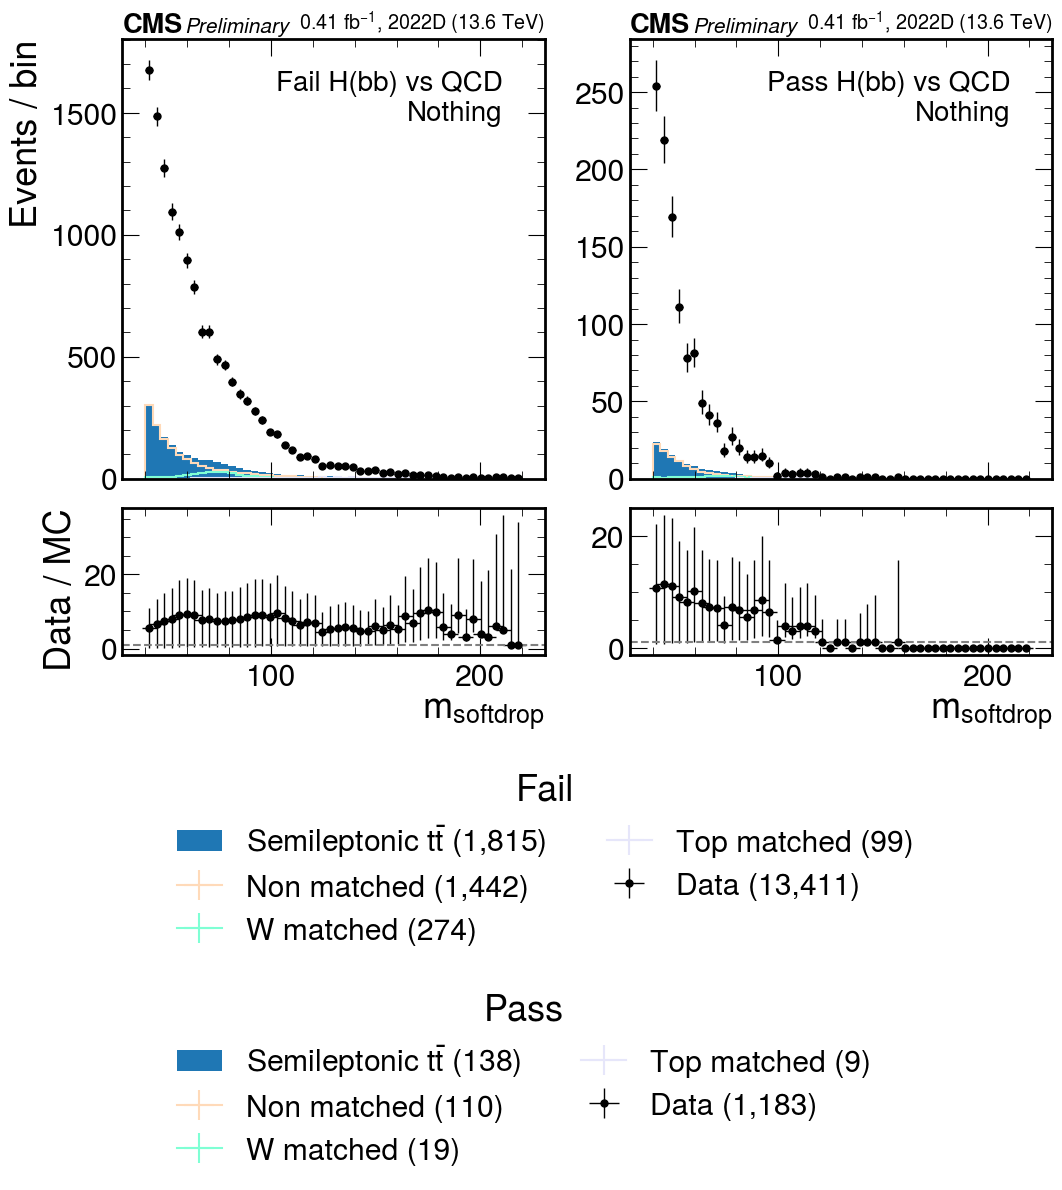

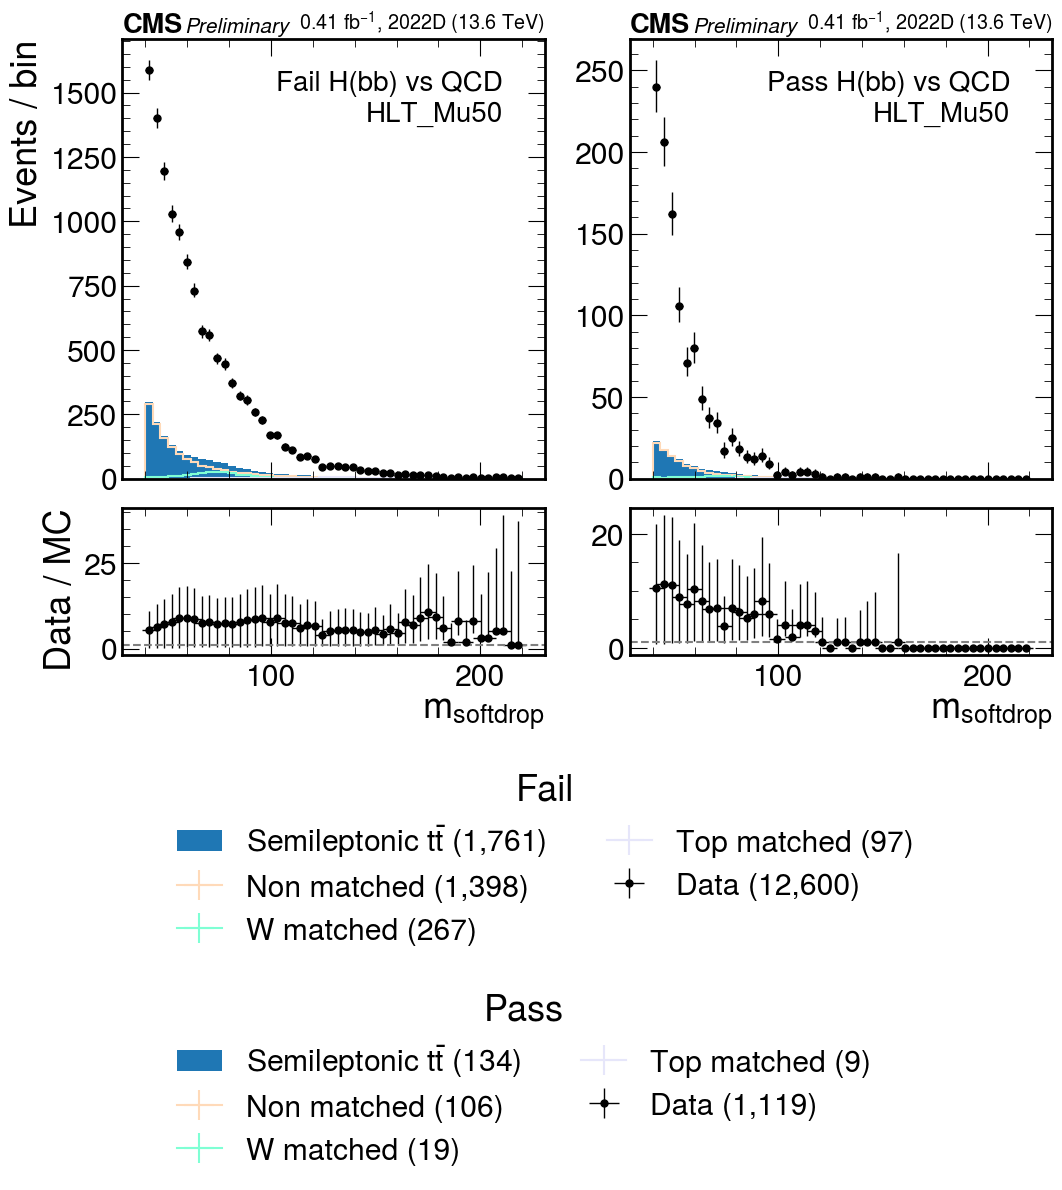

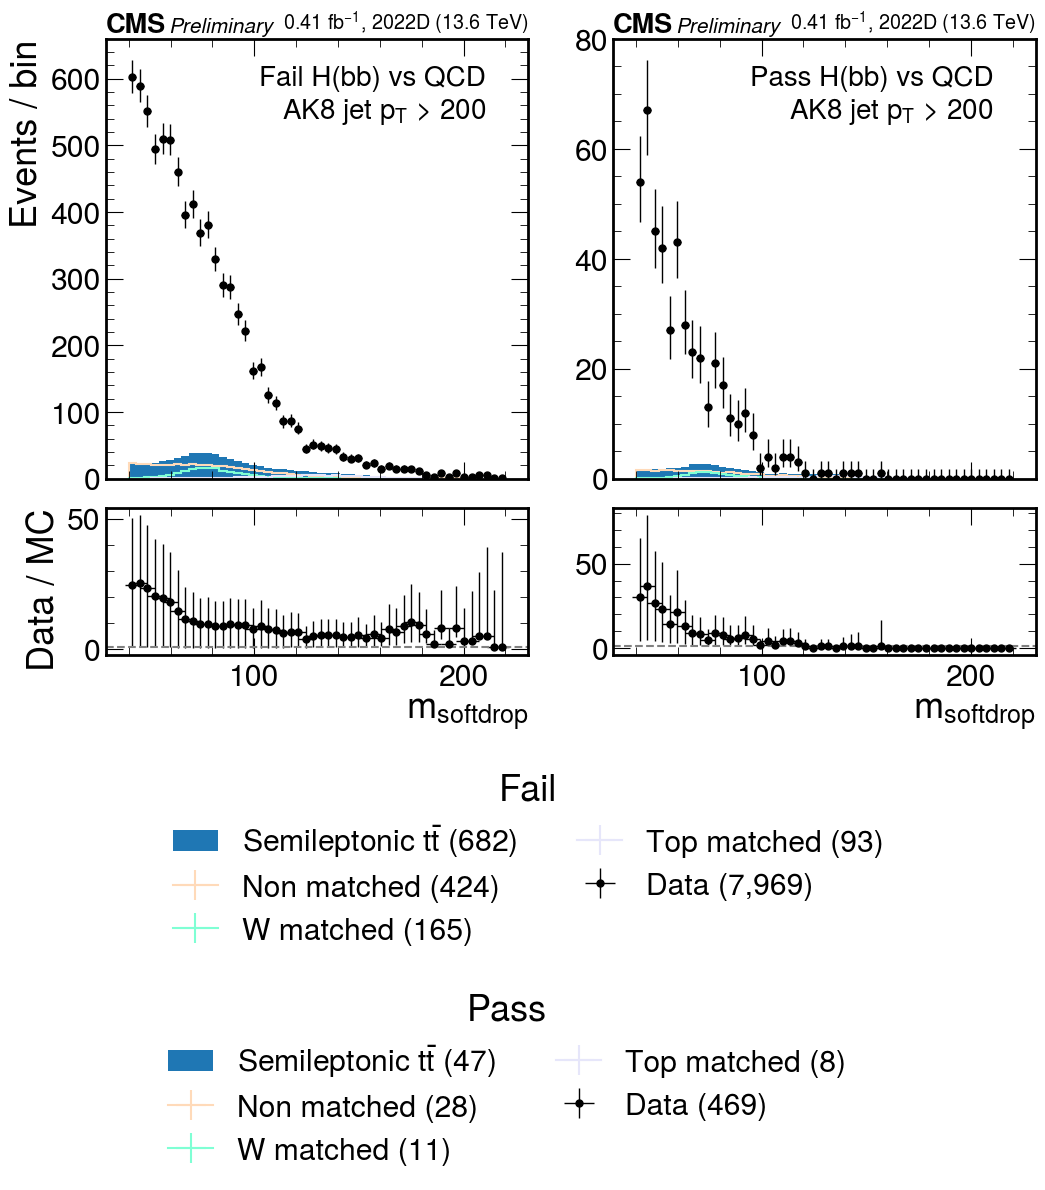

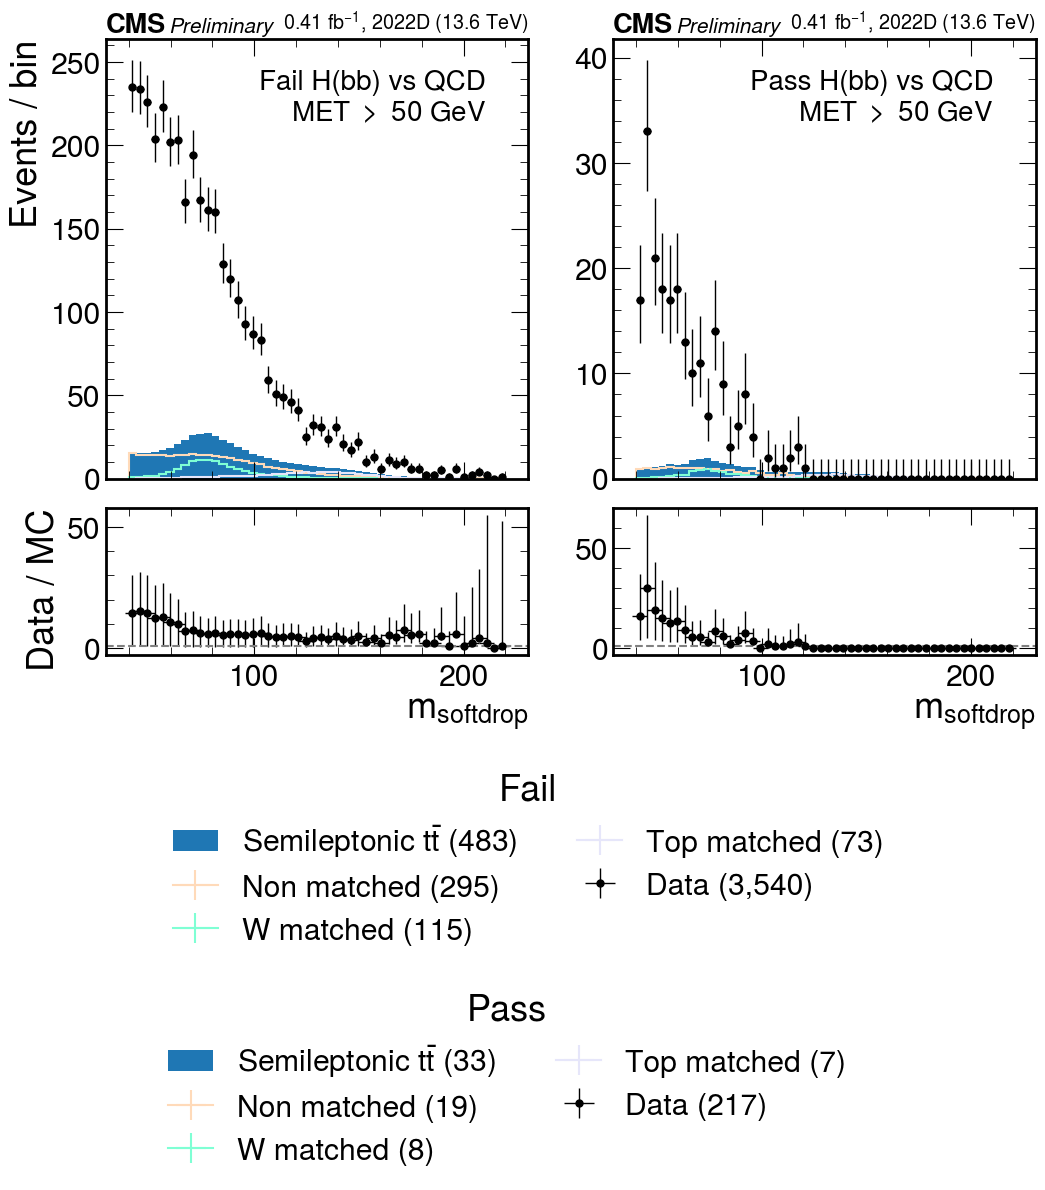

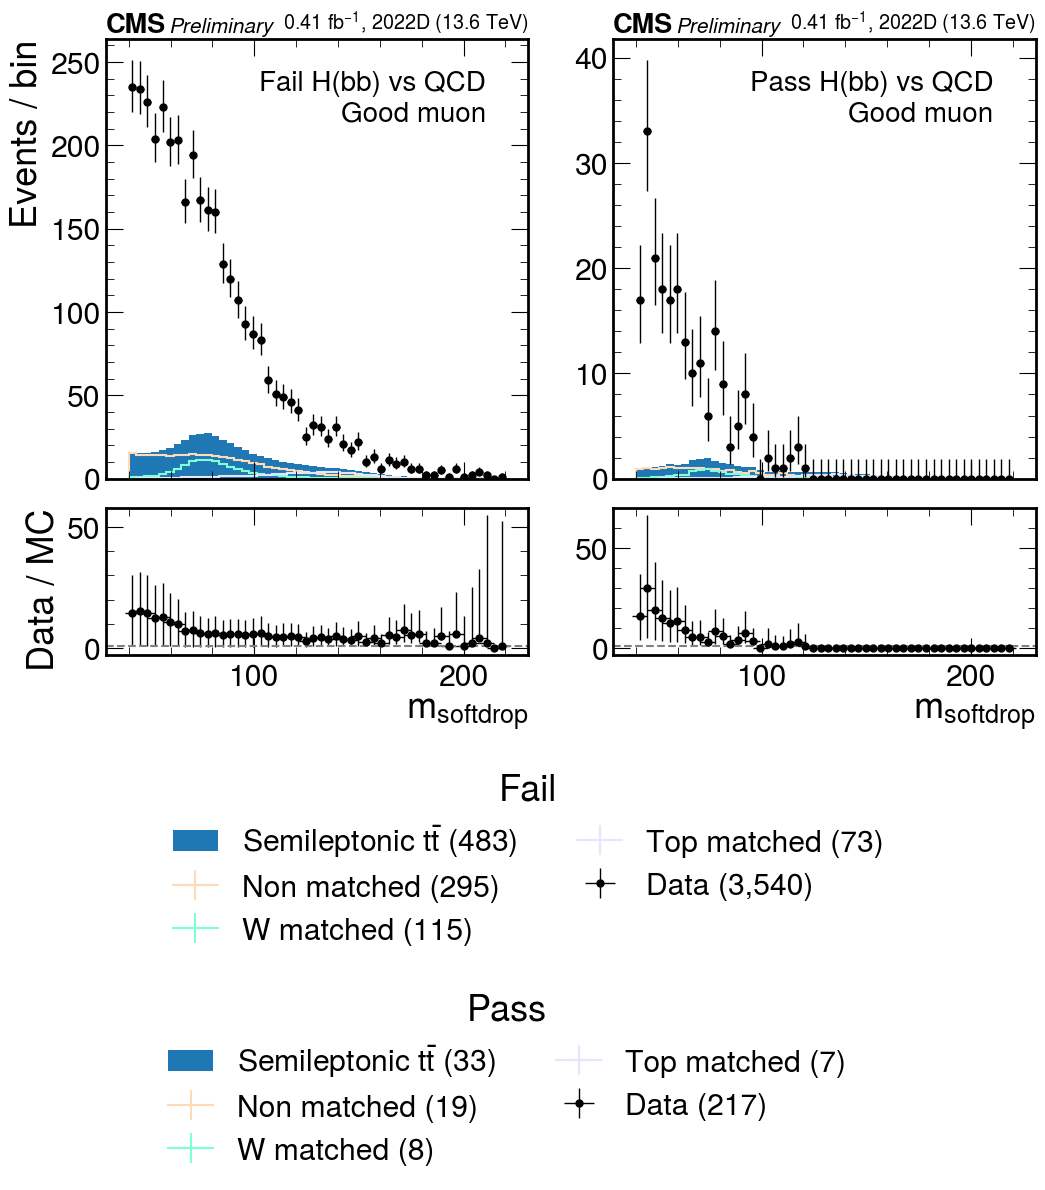

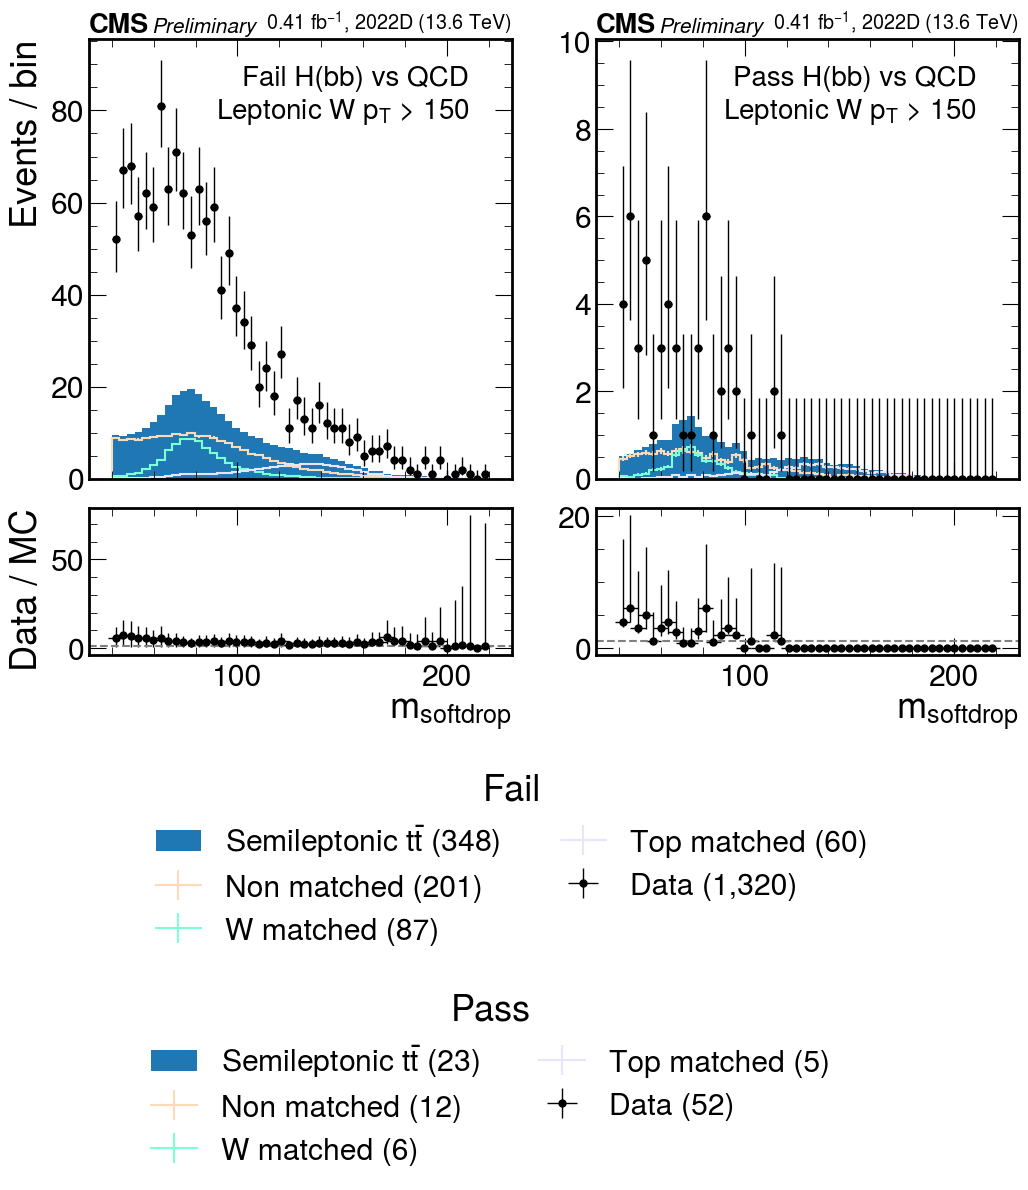

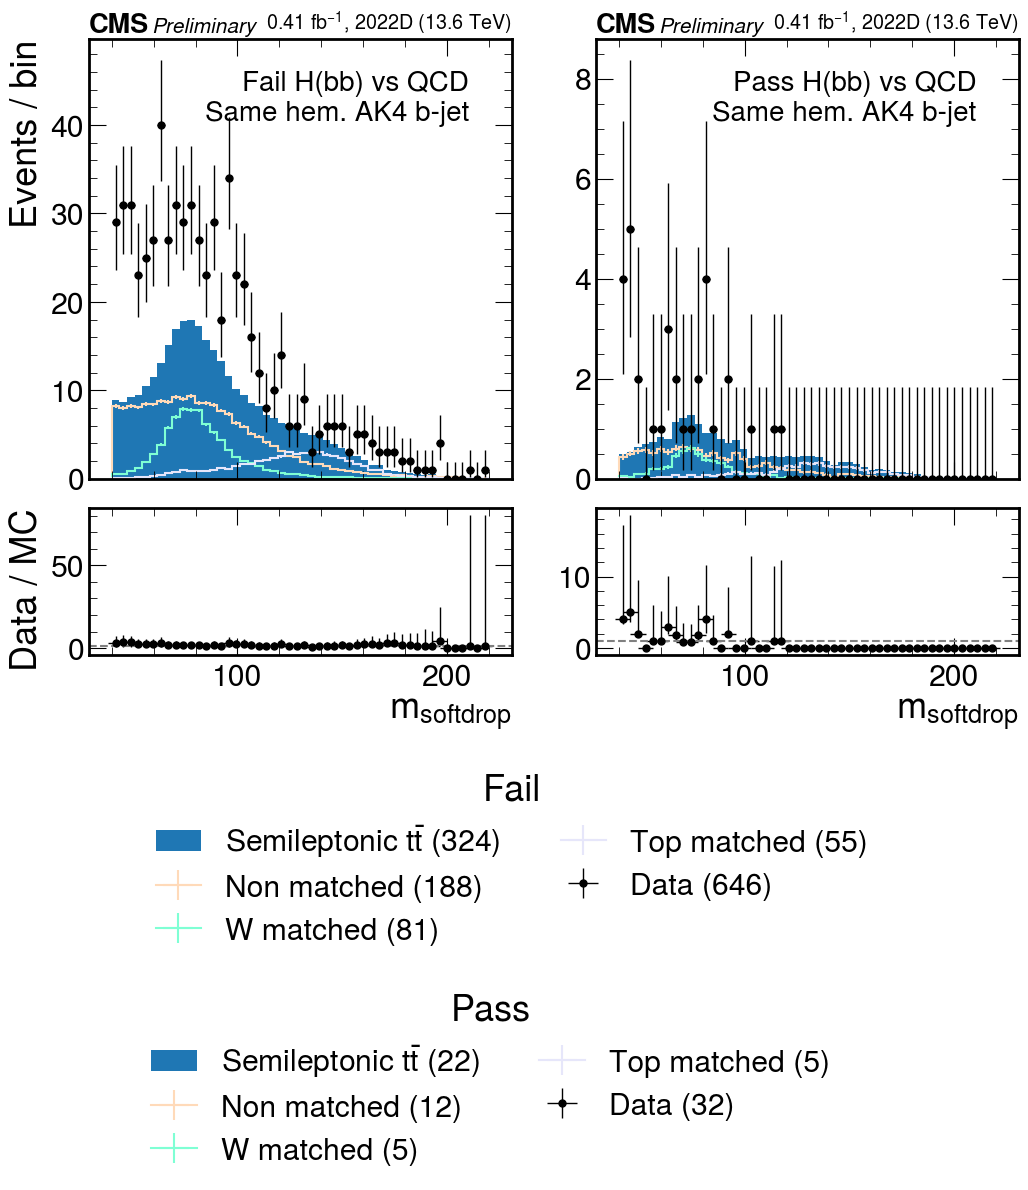

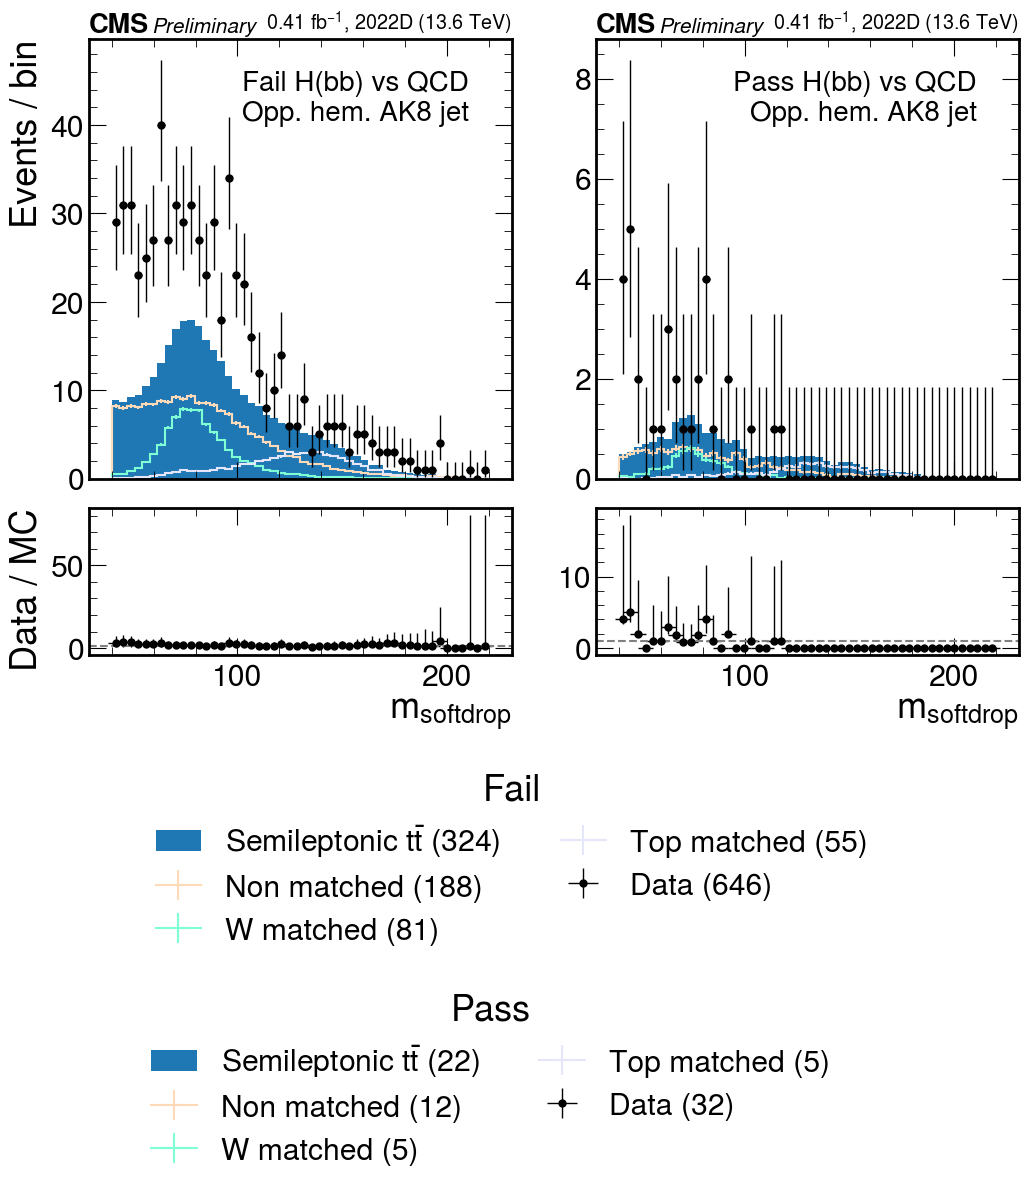

In [12]:
from coffea.hist import clopper_pearson_interval, poisson_interval

data = util.load("outfiles/cutflow_Run2022D.coffea")[0]
mc = util.load("outfiles/cutflow_TTtoLNu2Q_backup.coffea")

lumis = {
    "2022d" : 405.716280863,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'HLT_Mu50',
    'AK8 jet p$_T$ > 200',
    'MET $>$ 50 GeV',
    'Good muon',
    'Leptonic W p$_T$ > 150',
    'Same hem. AK4 b-jet',
    'Opp. hem. AK8 jet',
]

region = {
    0 : "Fail H(bb) vs QCD",
    1 : "Pass H(bb) vs QCD",
}

hist_data = {}
hist_mc = {}

scale_lumi = {k: xs[k] * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "cat" : slice(hist.underflow, hist.overflow, sum),
    "dataset" : slice(hist.underflow, hist.overflow, sum),
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 2, figsize=(12, 8), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    
    for j, r in enumerate(["fail", "pass"]):
    
        fig.subplots_adjust(hspace=0.1)
        ax[j].set_ylabel("Events / bin" if j == 0 else " ")
        rax[j].set_ylabel("Data / MC" if j == 0 else " ")
        rax[j].set_xlabel(r"m$_{softdrop}$")
        ax[j].set_xlabel(" ")

        sli = slice(hist.underflow, 0.4j, sum) if j == 0 else slice(0.4j, hist.overflow, sum)
        hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : sli}]
        hist_mc[r] = hh_mc

        mplhep.histplot(
            hh_mc[{"cat" : sum}],
            ax=ax[j], 
            histtype="fill",
            label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})"
        )

        mplhep.histplot(
            [
                hh_mc[{"cat" : hist.loc("non_matched")}],
                hh_mc[{"cat" : hist.loc("w_matched")}],
                hh_mc[{"cat" : hist.loc("top_matched")}],
            ],
            ax=ax[j],
            label=[
                "Non matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("non_matched")}].sum().value),
                "W matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("w_matched")}].sum().value),
                "Top matched ({0:,.0f})".format(hh_mc[{"cat" : hist.loc("top_matched")}].sum().value),
            ],
            color=["peachpuff","aquamarine","lavender"]
        )

        hh_data = h_data[{"cut" : hist.loc(i), "pn_Hbb" : sli}]
        hist_data[r] = hh_data

        mplhep.histplot(
            hh_data, 
            ax=ax[j], 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data ({hh_data.sum().value:,.0f})"
        )

        centers = hh_data.axes[0].centers
        sumw_num, sumw2_num = hh_data.values(), hh_data.variances()
        sumw_denom, sumw2_denom = hh_mc[{"cat" : sum}].values(), hh_mc[{"cat" : sum}].variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        rax[j].errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax[j].axhline(1, color='gray',ls='--')

        plt.text(0.9, 0.8, f"{region[j]}\n{cuts[i]}",
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform=ax[j].transAxes
                   )

        mplhep.cms.label(
            ax=ax[j], 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
            fontsize=15,
        )

    ax[0].legend(loc='upper center', title="Fail", bbox_to_anchor=(1, -0.6), ncol=2)
    ax[1].legend(loc='upper center', title="Pass", bbox_to_anchor=(-0.25, -1.1), ncol=2)

In [13]:
hist_data

{'fail': Hist(Regular(50, 40, 220, name='msoftdrop'), storage=Weight()) # Sum: WeightedSum(value=646, variance=646) (WeightedSum(value=1403, variance=1403) with flow),
 'pass': Hist(Regular(50, 40, 220, name='msoftdrop'), storage=Weight()) # Sum: WeightedSum(value=32, variance=32) (WeightedSum(value=125, variance=125) with flow)}

In [14]:
hist_mc

{'fail': Hist(
   StrCategory(['nan', 'non_matched', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
   Regular(50, 40, 220, name='msoftdrop'),
   storage=Weight()) # Sum: WeightedSum(value=323.981, variance=1.82414) (WeightedSum(value=456.821, variance=2.56305) with flow),
 'pass': Hist(
   StrCategory(['nan', 'non_matched', 'w_matched', 'top_matched'], growth=True, name='cat', label='Category'),
   Regular(50, 40, 220, name='msoftdrop'),
   storage=Weight()) # Sum: WeightedSum(value=21.711, variance=0.123337) (WeightedSum(value=36.3881, variance=0.20495) with flow)}

In [15]:
import uproot

with uproot.recreate("outfiles/histograms.root") as fout:
    for region in ["fail", "pass"]:
        fout[f"data_obs_{region}_nominal"] = hist_data[region]

        for matched in ["non_matched", "w_matched", "top_matched"]:
            fout[f"{matched.split('_')[0]}_{region}_nominal"] = hist_mc[region][{"cat" : hist.loc(matched)}]

In [17]:
with uproot.open("outfiles/histograms.root") as fin:
    for key, value in fin.items():
        print(key)

data_obs_fail_nominal;1
non_fail_nominal;1
w_fail_nominal;1
top_fail_nominal;1
data_obs_pass_nominal;1
non_pass_nominal;1
w_pass_nominal;1
top_pass_nominal;1
